# Initialisation

In [1]:
import sys
import notebook
import re
import subprocess
import os
import time
import random
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import gc
from tabulate import tabulate
import pickle
import shap
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer, log_loss, average_precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from joblib import parallel_backend
from pathlib import Path

d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/Pro/OpenClassrooms/Projet_7/tmp"

In [3]:
packages = {
    "Python": sys,
    "Jupyter Notebook": "notebook",
    "NumPy": "numpy",
    "Pandas": "pandas",
    "Matplotlib": "matplotlib",
    "Seaborn": "seaborn",
    "MLflow" : "mlflow",
    "Scikit-Learn": "sklearn",
    "Imbalanced Learn" :"imblearn",
    "LightGMB": "lightgbm",
    "SHAP" : "shap"
}

In [4]:
errorMsg = (
    "non disponible - vérifiez que le package existe, qu'il est correctement installé, importé "
    "et qu'il dispose d'un attribut '__version__'."
)
for name, module in packages.items():
    if isinstance(module, str):
        version = getattr(sys.modules.get(module, None), '__version__', errorMsg)
    else:
        if module is sys:
            version = sys.version
        else:
            version = getattr(module, '__version__', errorMsg)

    print(f"Version de {name} : {version}")

Version de Python : 3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]
Version de Jupyter Notebook : 7.3.2
Version de NumPy : 2.1.3
Version de Pandas : 2.2.3
Version de Matplotlib : 3.10.0
Version de Seaborn : 0.13.2
Version de MLflow : 2.19.0
Version de Scikit-Learn : 1.6.1
Version de Imbalanced Learn : 0.13.0
Version de LightGMB : 4.5.0
Version de SHAP : 0.46.0


In [5]:
# Chemins
pro_repo = "D://Pro//OpenClassrooms//Projet_7//"
data_path = f"{pro_repo}data//"

In [6]:
def read_csv_with_fallback(filepath, encodings=['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']):
    """
    Lecture d'un fichier CSV avec tentative sur plusieurs encodages.

    Parameters:
    - filepath (str): Chemin du fichier à lire.
    - encodings (list): Liste des encodages à tester.

    Returns:
    - pd.DataFrame: Le DataFrame pandas chargé.

    Raises:
    - UnicodeDecodeError: Si aucun des encodages ne fonctionne.
    """
    for encoding in encodings:
        try:
            print(f"Tentative de lecture avec l'encodage : {encoding}")
            return pd.read_csv(filepath, encoding=encoding)
        except UnicodeDecodeError:
            print(f"Erreur avec l'encodage : {encoding}")

    raise UnicodeDecodeError(f"Impossible de lire le fichier {filepath} avec les encodages {encodings}")

In [7]:
# Lecture des données
file_names = [
    "application_test", "application_train", "bureau", "bureau_balance", "credit_card_balance",
    "homecredit_columns_description", "installments_payments", "pos_cash_balance", "previous_application"
]

# Chargement des fichiers
loaded_data = {}
for file in file_names:
    filepath = data_path + file.lower() + ".csv"
    loaded_data[file] = read_csv_with_fallback(filepath)
    print(f"{file} chargé avec succès !")

Tentative de lecture avec l'encodage : utf-8
application_test chargé avec succès !
Tentative de lecture avec l'encodage : utf-8
application_train chargé avec succès !
Tentative de lecture avec l'encodage : utf-8
bureau chargé avec succès !
Tentative de lecture avec l'encodage : utf-8
bureau_balance chargé avec succès !
Tentative de lecture avec l'encodage : utf-8
credit_card_balance chargé avec succès !
Tentative de lecture avec l'encodage : utf-8
Erreur avec l'encodage : utf-8
Tentative de lecture avec l'encodage : latin1
homecredit_columns_description chargé avec succès !
Tentative de lecture avec l'encodage : utf-8
installments_payments chargé avec succès !
Tentative de lecture avec l'encodage : utf-8
pos_cash_balance chargé avec succès !
Tentative de lecture avec l'encodage : utf-8
previous_application chargé avec succès !


In [8]:
# Assignation des DataFrames
app_train = loaded_data["application_train"]
app_test = loaded_data["application_test"]
bureau = loaded_data["bureau"]
bureau_balance = loaded_data["bureau_balance"]
credit_card = loaded_data["credit_card_balance"]
insta_payments = loaded_data["installments_payments"]
pos_cash = loaded_data["pos_cash_balance"]
previous = loaded_data["previous_application"]

In [9]:
# Aperçu des données
for name, df in loaded_data.items():
    print(f"{name.capitalize()} Info:")
    print(df.info(), "\n")

Application_test Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None 

Application_train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None 

Bureau Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  f

In [10]:
print(f"Taille du jeu d'entraînement initial : {app_train.shape}")
print(f"Taille du jeu de test initial : {app_test.shape}")

Taille du jeu d'entraînement initial : (307511, 122)
Taille du jeu de test initial : (48744, 121)


# Prétraitement & Feature engineering

In [11]:
def create_features(df, bureau, previous, pos_cash, insta_payments, credit_card):
    """
    Crée des features à partir des données disponibles.

    Parameters:
    - df (pd.DataFrame): DataFrame principal (train ou test).
    - bureau (pd.DataFrame): Données des crédits passés.
    - previous (pd.DataFrame): Données des applications précédentes.
    - pos_cash (pd.DataFrame): Données POS/CASH.
    - insta_payments (pd.DataFrame): Données des paiements.
    - credit_card (pd.DataFrame): Données des cartes de crédit.

    Returns:
    - pd.DataFrame: DataFrame enrichi avec les nouvelles features.
    """
    # 1. Features directes
    df["CREDIT_TERM"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]
    df["ANNUITY_INCOME_PERCENT"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]

    # 2. Features issues de bureau
    bureau["DEBT_CREDIT_RATIO"] = bureau["AMT_CREDIT_SUM_DEBT"] / bureau["AMT_CREDIT_SUM"]
    bureau["DEBT_CREDIT_RATIO"] = bureau["DEBT_CREDIT_RATIO"].replace([np.inf, -np.inf], 0).fillna(0)
    debt_credit_ratio = bureau.groupby("SK_ID_CURR")["DEBT_CREDIT_RATIO"].mean()
    df = df.merge(debt_credit_ratio, on="SK_ID_CURR", how="left")
    df["DEBT_CREDIT_RATIO"] = df["DEBT_CREDIT_RATIO"].replace([np.inf, -np.inf], np.nan)

    # 3. Features issues de previous
    prev_cnt_payment = previous.groupby("SK_ID_CURR")["CNT_PAYMENT"].mean()
    df = df.merge(prev_cnt_payment, on="SK_ID_CURR", how="left")
    df.rename(columns={"CNT_PAYMENT": "PREV_CNT_PAYMENT"}, inplace=True)
    df["PREV_CNT_PAYMENT"] = df["PREV_CNT_PAYMENT"].replace([np.inf, -np.inf], np.nan)


    # 4. Features issues de POS_CASH_balance
    pos_cnt_instalment_future = pos_cash.groupby("SK_ID_CURR")["CNT_INSTALMENT_FUTURE"].mean()
    df = df.merge(pos_cnt_instalment_future, on="SK_ID_CURR", how="left")
    df.rename(columns={"CNT_INSTALMENT_FUTURE": "POS_CNT_INSTALMENT_FUTURE"}, inplace=True)
    df["POS_CNT_INSTALMENT_FUTURE"] = df["POS_CNT_INSTALMENT_FUTURE"].replace([np.inf, -np.inf], np.nan)


    # 5. Features issues d'installments_payments
    # Agrégation pour NUM_INSTALMENT_VERSION
    insta_num_instalment_version = insta_payments.groupby("SK_ID_CURR")["NUM_INSTALMENT_VERSION"].mean()
    insta_num_instalment_version.name = "INSTA_NUM_INSTALMENT_VERSION"
    # Agrégation pour AMT_PAYMENT
    insta_amt_payment = insta_payments.groupby("SK_ID_CURR")["AMT_PAYMENT"].mean()
    insta_amt_payment.name = "INSTA_AMT_PAYMENT"
    # Fusion
    df = df.merge(insta_num_instalment_version, on="SK_ID_CURR", how="left")
    df = df.merge(insta_amt_payment, on="SK_ID_CURR", how="left")
    df["INSTA_NUM_INSTALMENT_VERSION"] = df["INSTA_NUM_INSTALMENT_VERSION"].replace([np.inf, -np.inf], np.nan)
    df["INSTA_AMT_PAYMENT"] = df["INSTA_AMT_PAYMENT"].replace([np.inf, -np.inf], np.nan)

    # 6. Features issues des scores par groupes
    df["CREDIT_GOODS_RATIO"] = df["AMT_CREDIT"] / (df["AMT_GOODS_PRICE"] + 1e-5)
    df["ANNUITY_BIRTH_RATIO"] = df["AMT_ANNUITY"] / (df["DAYS_BIRTH"].abs() / 365)
    df["PUBLISH_REGISTRATION_RATIO"] = df["DAYS_ID_PUBLISH"] / (df["DAYS_REGISTRATION"] + 1e-5)

    return df

In [12]:
# Créer les features pour les deux datasets
app_train = create_features(app_train, bureau, previous, pos_cash, insta_payments, credit_card)
app_test = create_features(app_test, bureau, previous, pos_cash, insta_payments, credit_card)

# Liste des features
features = sorted([
    "AMT_ANNUITY", "AMT_CREDIT", "AMT_GOODS_PRICE", "ANNUITY_BIRTH_RATIO",
    "ANNUITY_INCOME_PERCENT", "CREDIT_GOODS_RATIO", "CREDIT_TERM",
    "DEBT_CREDIT_RATIO", "DAYS_BIRTH", "DAYS_ID_PUBLISH", "DAYS_REGISTRATION",
    "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "INSTA_AMT_PAYMENT",
    "INSTA_NUM_INSTALMENT_VERSION", "POS_CNT_INSTALMENT_FUTURE",
    "PREV_CNT_PAYMENT", "PUBLISH_REGISTRATION_RATIO"
])

# Sélection des features finales
app_train = app_train[["SK_ID_CURR", "TARGET"] + features]
app_test = app_test[["SK_ID_CURR"] + features]

# Vérification des données
print(f"Taille du jeu d'entraînement final: {app_train.shape}")
print(f"Taille du jeu de test final: {app_test.shape}")

Taille du jeu d'entraînement final: (307511, 21)
Taille du jeu de test final: (48744, 20)


In [13]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  int64  
 1   TARGET                        307511 non-null  int64  
 2   AMT_ANNUITY                   307499 non-null  float64
 3   AMT_CREDIT                    307511 non-null  float64
 4   AMT_GOODS_PRICE               307233 non-null  float64
 5   ANNUITY_BIRTH_RATIO           307499 non-null  float64
 6   ANNUITY_INCOME_PERCENT        307499 non-null  float64
 7   CREDIT_GOODS_RATIO            307233 non-null  float64
 8   CREDIT_TERM                   307499 non-null  float64
 9   DAYS_BIRTH                    307511 non-null  int64  
 10  DAYS_ID_PUBLISH               307511 non-null  int64  
 11  DAYS_REGISTRATION             307511 non-null  float64
 12  DEBT_CREDIT_RATIO             263491 non-nul

In [14]:
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SK_ID_CURR                    48744 non-null  int64  
 1   AMT_ANNUITY                   48720 non-null  float64
 2   AMT_CREDIT                    48744 non-null  float64
 3   AMT_GOODS_PRICE               48744 non-null  float64
 4   ANNUITY_BIRTH_RATIO           48720 non-null  float64
 5   ANNUITY_INCOME_PERCENT        48720 non-null  float64
 6   CREDIT_GOODS_RATIO            48744 non-null  float64
 7   CREDIT_TERM                   48720 non-null  float64
 8   DAYS_BIRTH                    48744 non-null  int64  
 9   DAYS_ID_PUBLISH               48744 non-null  int64  
 10  DAYS_REGISTRATION             48744 non-null  float64
 11  DEBT_CREDIT_RATIO             42320 non-null  float64
 12  EXT_SOURCE_1                  28212 non-null  float64
 13  E

In [15]:
app_train.head(5)

,SK_ID_CURR,TARGET,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,ANNUITY_BIRTH_RATIO,ANNUITY_INCOME_PERCENT,CREDIT_GOODS_RATIO,CREDIT_TERM,DAYS_BIRTH,...,DAYS_REGISTRATION,DEBT_CREDIT_RATIO,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,INSTA_AMT_PAYMENT,INSTA_NUM_INSTALMENT_VERSION,POS_CNT_INSTALMENT_FUTURE,PREV_CNT_PAYMENT,PUBLISH_REGISTRATION_RATIO
0,100002,1,24700.5,406597.5,351000.0,952.931244,0.121978,1.158397,16.461104,-9461,...,-3648.0,0.068272,0.083037,0.262949,0.139376,11559.247105,1.052632,15.000000,24.000000,0.581140
1,100003,0,35698.5,1293502.5,1129500.0,777.211602,0.132217,1.145199,36.234085,-16765,...,-1186.0,0.000000,0.311267,0.622246,NaN,64754.586000,1.040000,5.785714,10.000000,0.245363
2,100004,0,6750.0,135000.0,135000.0,129.357870,0.100000,1.000000,20.000000,-19046,...,-4260.0,0.000000,NaN,0.555912,0.729567,7096.155000,1.333333,2.250000,4.000000,0.594131
3,100006,0,29686.5,312682.5,297000.0,570.143252,0.219900,1.052803,10.532818,-19005,...,-9833.0,NaN,NaN,0.650442,NaN,62947.088438,1.125000,8.650000,23.000000,0.247839
4,100007,0,21865.5,513000.0,513000.0,400.406758,0.179963,1.000000,23.461618,-19932,...,-4311.0,0.000000,NaN,0.322738,NaN,12214.060227,1.166667,8.969697,20.666667,0.802134


In [16]:
app_test.head(5)

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,ANNUITY_BIRTH_RATIO,ANNUITY_INCOME_PERCENT,CREDIT_GOODS_RATIO,CREDIT_TERM,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DEBT_CREDIT_RATIO,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,INSTA_AMT_PAYMENT,INSTA_NUM_INSTALMENT_VERSION,POS_CNT_INSTALMENT_FUTURE,PREV_CNT_PAYMENT,PUBLISH_REGISTRATION_RATIO
0,100001,20560.5,568800.0,450000.0,390.030794,0.152300,1.2640,27.664697,-19241,-812,-5170.0,0.282518,0.752614,0.789654,0.159520,5885.132143,1.142857,1.444444,8.000000,0.157060
1,100005,17370.0,222768.0,180000.0,350.977081,0.175455,1.2376,12.824870,-18064,-1623,-9118.0,0.601256,0.564990,0.291656,0.432962,6240.205000,1.111111,7.200000,12.000000,0.178000
2,100013,69777.0,663264.0,630000.0,1271.015321,0.344578,1.0528,9.505482,-20038,-3503,-2175.0,0.000000,NaN,0.699787,0.610991,9740.235774,0.277419,15.305556,17.333333,1.610575
3,100028,49018.5,1575000.0,1575000.0,1280.176910,0.155614,1.0000,32.130726,-13976,-4208,-2000.0,0.091700,0.525734,0.509677,0.612704,4356.731549,0.460177,10.129032,11.333333,2.104000
4,100038,32067.0,625500.0,625500.0,897.580905,0.178150,1.0000,19.506034,-13040,-4262,-4000.0,NaN,0.202145,0.425687,NaN,11100.337500,1.000000,5.846154,24.000000,1.065500


# Analyses

In [17]:
# Réglages globaux pour les graphiques
sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (18, 36), 'axes.titlesize': 14, 'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

## Distributions

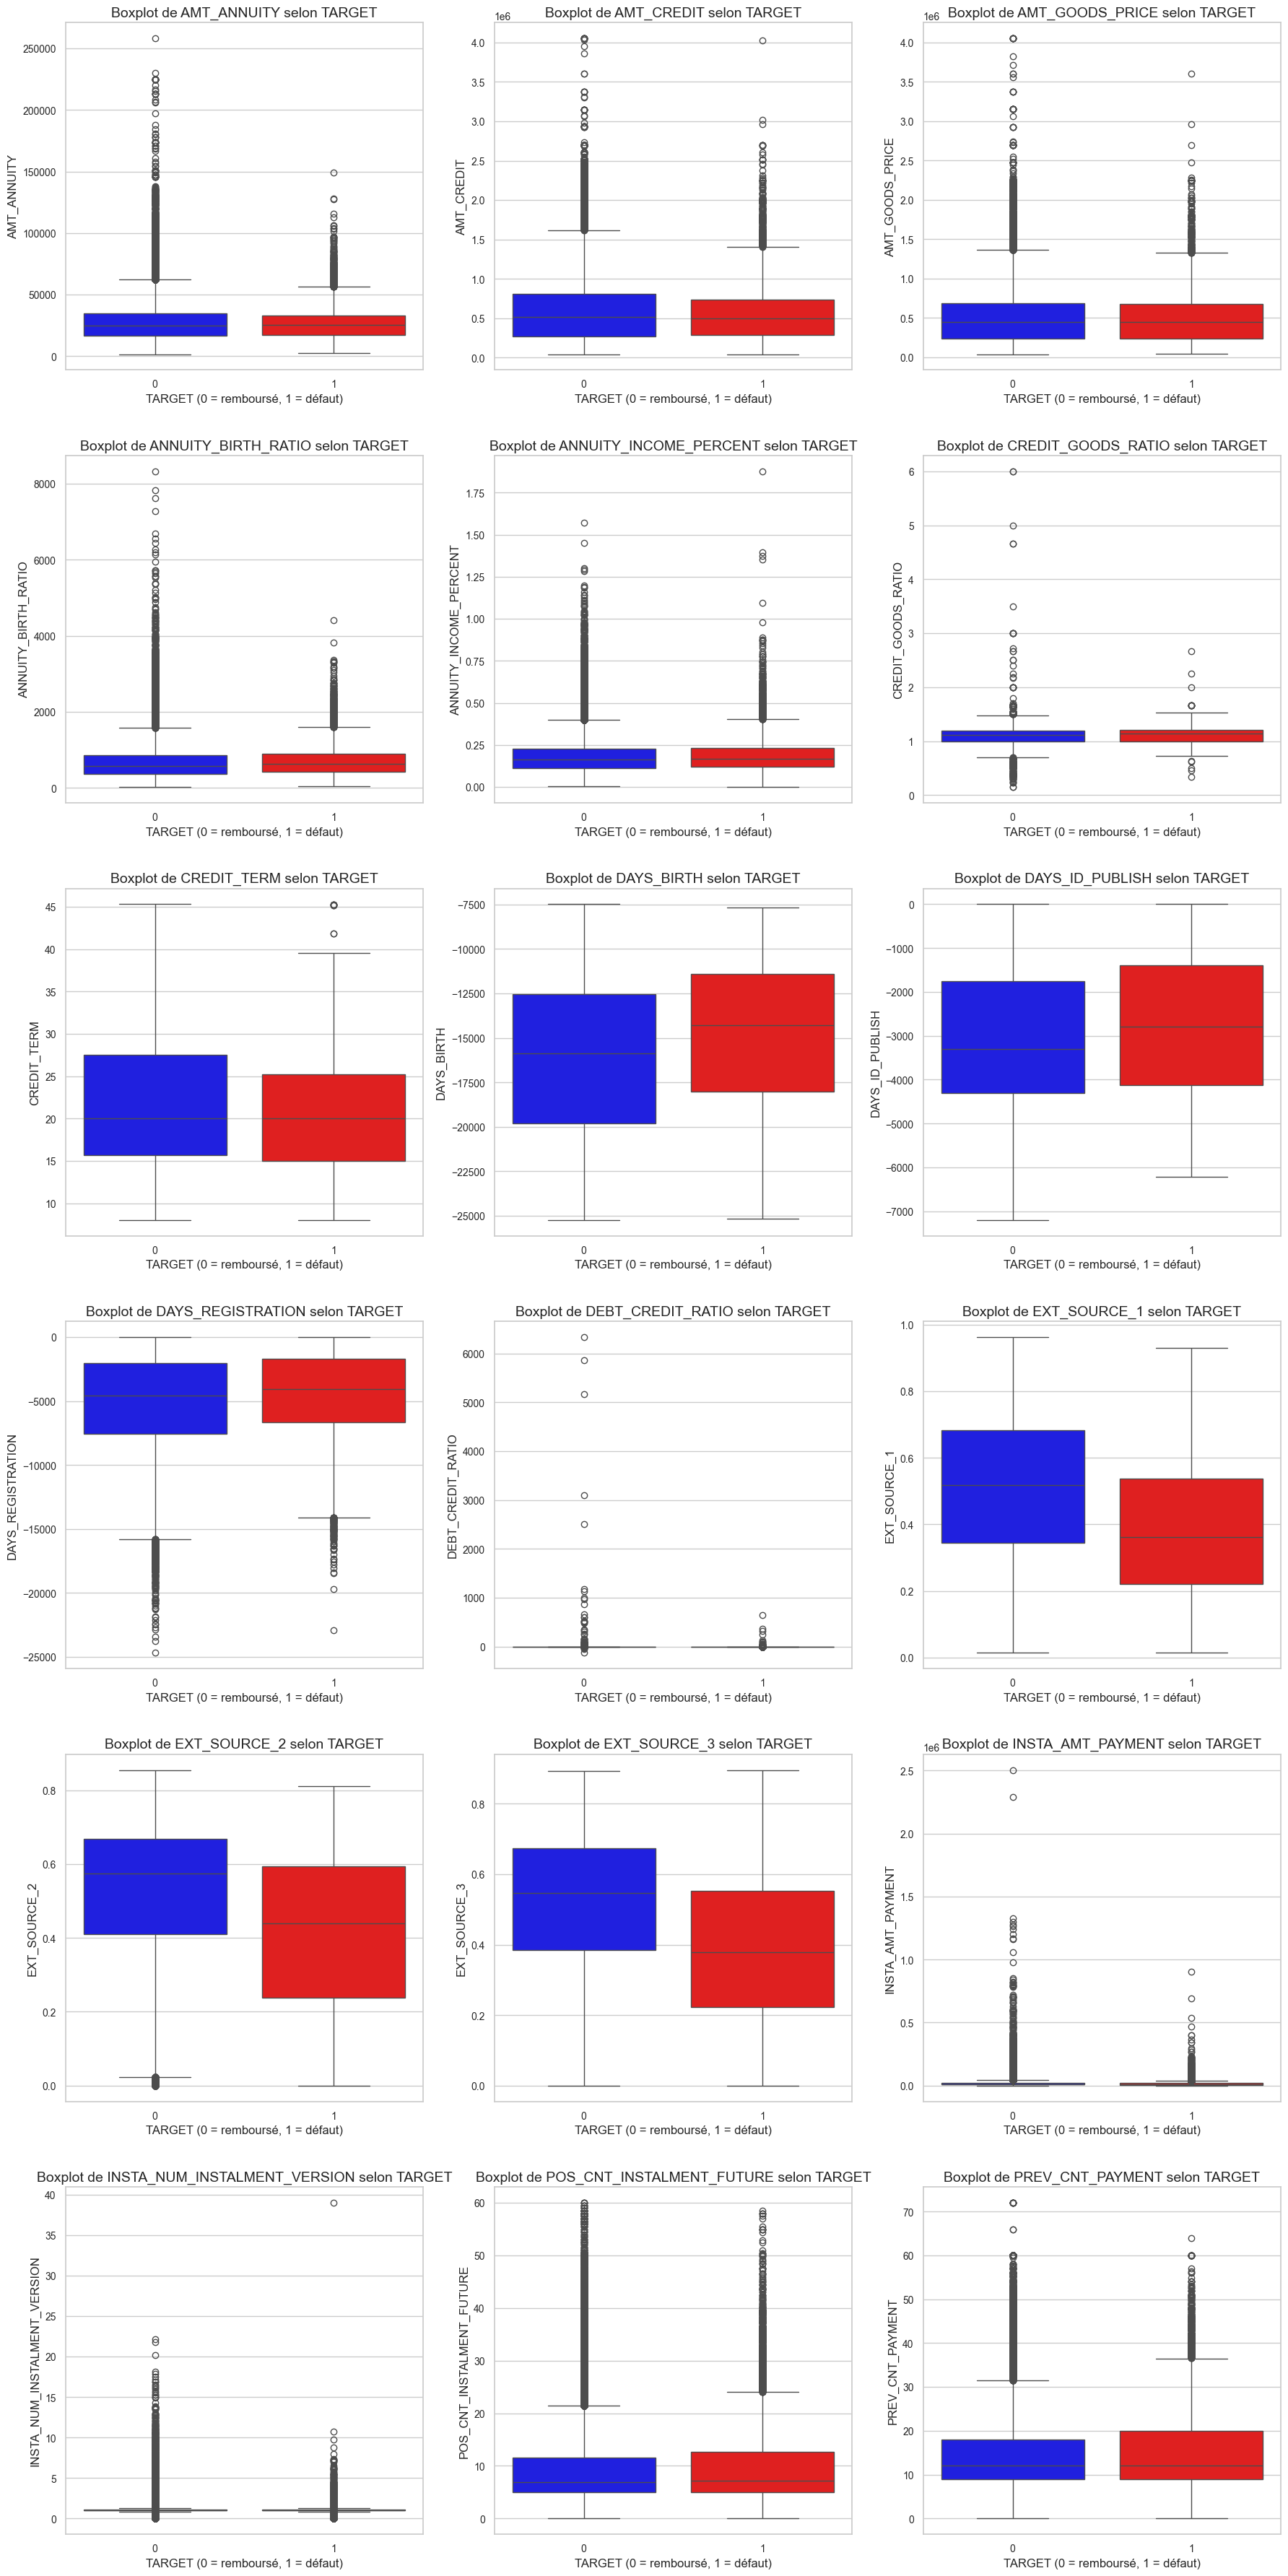

In [18]:
# Limiter à 18 figures pour éviter l'erreur liée à la grille
columns_to_plot = features[:18]

# Création des sous-graphiques
fig, axes = plt.subplots(6, 3, figsize=(18, 36))  # Dimensions pour 6 lignes x 3 colonnes
axes = axes.flatten()  # Aplatir pour itération

for i, feature in enumerate(columns_to_plot):
    ax = axes[i]

    # Création du boxplot avec distinction de la variable TARGET
    sns.boxplot(
        data=app_train,
        x="TARGET",
        y=feature,
        ax=ax,
        showfliers=True,  # Affichage des outliers
        whis=1.5,  # Définition des valeurs extrêmes via la règle de Tukey
        hue="TARGET",  # Ajout pour corriger le warning
        hue_order=[0, 1],  # Ordre des classes
        palette={0: "blue", 1: "red"}  # Correction des clés du dictionnaire
    )

    # Titres et labels
    ax.set_title(f'Boxplot de {feature} selon TARGET')
    ax.set_xlabel("TARGET (0 = remboursé, 1 = défaut)")
    ax.set_ylabel(feature)
    ax.legend_.remove()  # Suppression de la légende inutile dans chaque subplot

# Supprimer les axes inutilisés si le nombre de colonnes est inférieur à 18
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(h_pad=2.0)
plt.show()

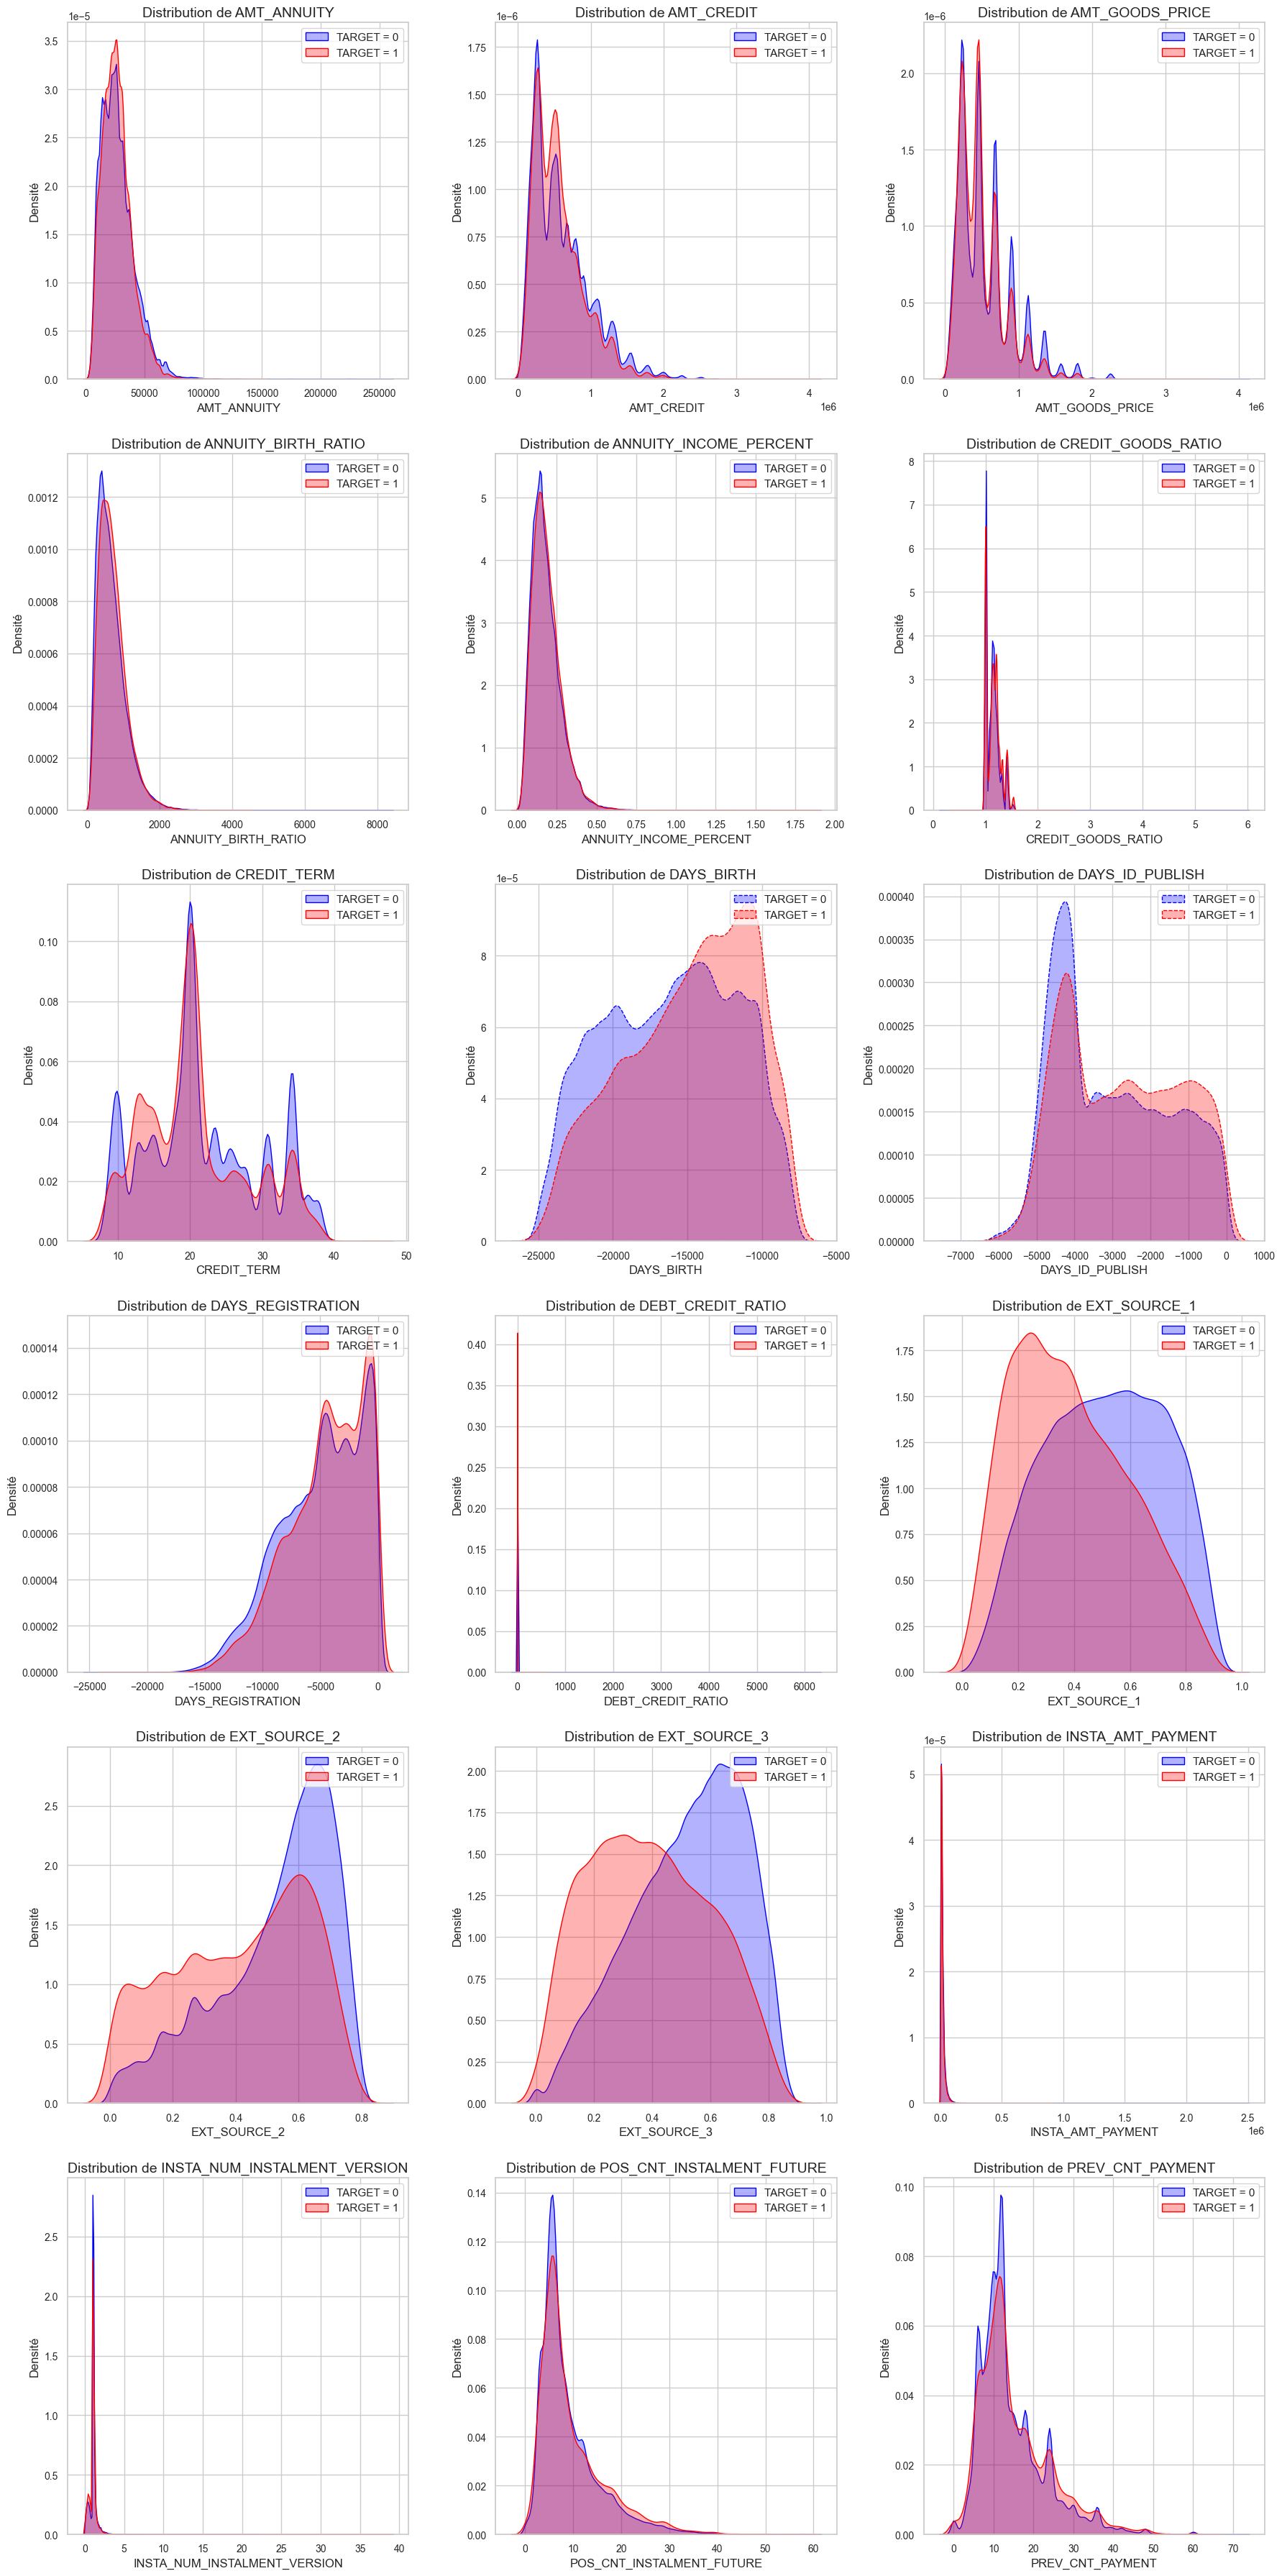

In [19]:
# Limiter à 18 figures pour éviter l'erreur liée à la grille
columns_to_plot = features[:18]

# Création des sous-graphiques
fig, axes = plt.subplots(6, 3, figsize=(18, 36))  # Dimensions pour 6 lignes x 3 colonnes
axes = axes.flatten()  # Aplatir pour itération

# Features avec des lignes pointillées
dashed_features = ["DAYS_BIRTH", "DAYS_ID_PUBLISH"]

for i, feature in enumerate(columns_to_plot):
    ax = axes[i]

    # Filtrer les données pour TARGET = 0 et TARGET = 1 en excluant les NaN
    data_0 = app_train.loc[app_train['TARGET'] == 0, feature].dropna()
    data_1 = app_train.loc[app_train['TARGET'] == 1, feature].dropna()

    # Vérification des données avant de tracer
    if len(data_0) > 1:
        sns.kdeplot(
            data_0, label='TARGET = 0', color='blue', fill=True, alpha=0.3,
            linestyle='--' if feature in dashed_features else '-', ax=ax
        )
    if len(data_1) > 1:
        sns.kdeplot(
            data_1, label='TARGET = 1', color='red', fill=True, alpha=0.3,
            linestyle='--' if feature in dashed_features else '-', ax=ax
        )

    # Titres et labels
    ax.set_title(f'Distribution de {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Densité')
    ax.legend(loc='upper right')

# Supprimer les axes inutilisés si le nombre de colonnes est inférieur à 18
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(h_pad=2.0)
plt.show()

## Corrélations

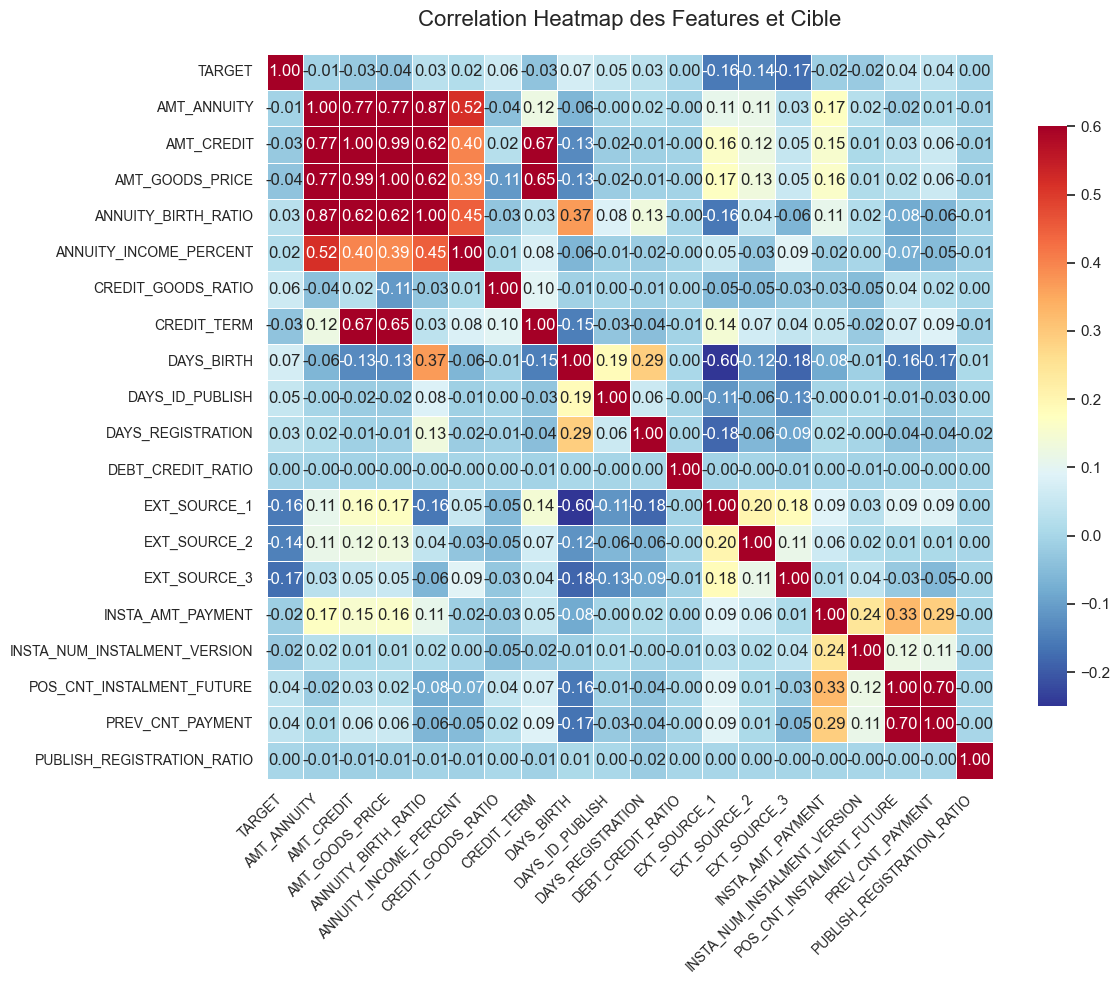

In [20]:
# Calcul de la matrice de corrélation pour les 18 features + la cible
columns_to_include = [
    "TARGET", "AMT_ANNUITY", "AMT_CREDIT", "AMT_GOODS_PRICE", "ANNUITY_BIRTH_RATIO",
    "ANNUITY_INCOME_PERCENT", "CREDIT_GOODS_RATIO", "CREDIT_TERM", "DAYS_BIRTH",
    "DAYS_ID_PUBLISH", "DAYS_REGISTRATION", "DEBT_CREDIT_RATIO", "EXT_SOURCE_1",
    "EXT_SOURCE_2", "EXT_SOURCE_3", "INSTA_AMT_PAYMENT", "INSTA_NUM_INSTALMENT_VERSION",
    "POS_CNT_INSTALMENT_FUTURE", "PREV_CNT_PAYMENT", "PUBLISH_REGISTRATION_RATIO"
]

# Filtrer les colonnes nécessaires et exclure les lignes avec des valeurs manquantes
corr_data = app_train[columns_to_include].dropna()

# Calcul de la matrice de corrélation
corr_matrix = corr_data.corr()

# Création de la heatmap
plt.figure(figsize=(12, 10))  # Dimensions ajustées pour lisibilité
sns.set_theme(style="whitegrid")

sns.heatmap(
    corr_matrix,
    cmap=plt.cm.RdYlBu_r,  # Palette de couleurs
    annot=True,            # Afficher les coefficients
    fmt=".2f",             # Format des annotations
    linewidths=0.5,        # Espacement entre les cellules
    cbar_kws={"shrink": 0.8},  # Taille de la barre de couleur
    vmin=-0.25, vmax=0.6   # Plage des valeurs
)

# Ajout du titre et ajustements esthétiques
plt.title('Correlation Heatmap des Features et Cible', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Affichage
plt.show()

In [21]:
# Calcul de la matrice de corrélation pour les features et la cible
correlation_matrix = app_train[columns_to_include].corr()

# Impression de la matrice de corrélation en texte
print("Matrice de corrélation :")
correlation_matrix

Matrice de corrélation :


,TARGET,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,ANNUITY_BIRTH_RATIO,ANNUITY_INCOME_PERCENT,CREDIT_GOODS_RATIO,CREDIT_TERM,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DEBT_CREDIT_RATIO,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,INSTA_AMT_PAYMENT,INSTA_NUM_INSTALMENT_VERSION,POS_CNT_INSTALMENT_FUTURE,PREV_CNT_PAYMENT,PUBLISH_REGISTRATION_RATIO
TARGET,1.000000,-0.012817,-0.030369,-0.039645,0.024395,0.014265,0.069427,-0.032102,0.078239,0.051457,0.041975,0.000716,-0.155317,-0.160472,-0.178919,-0.023169,-0.027323,0.027827,0.027743,-0.000246
AMT_ANNUITY,-0.012817,1.000000,0.770138,0.775109,0.860200,0.484624,-0.063545,0.115948,0.009445,0.011268,0.038514,-0.001211,0.119398,0.125804,0.030752,0.175477,0.026032,-0.034746,-0.003415,-0.004509
AMT_CREDIT,-0.030369,0.770138,1.000000,0.986968,0.619290,0.373921,0.017454,0.659264,-0.055436,-0.006575,0.009621,-0.003883,0.168429,0.131228,0.043516,0.159906,0.008617,0.025648,0.056181,-0.006598
AMT_GOODS_PRICE,-0.039645,0.775109,0.986968,1.000000,0.623948,0.368419,-0.115679,0.632199,-0.053442,-0.009267,0.011565,-0.003987,0.175502,0.139367,0.047717,0.165203,0.015679,0.022214,0.055289,-0.006870
ANNUITY_BIRTH_RATIO,0.024395,0.860200,0.619290,0.623948,1.000000,0.392264,-0.053236,0.033163,0.438937,0.122428,0.168992,0.000386,-0.146343,0.053709,-0.067360,0.110002,0.015403,-0.099123,-0.079712,-0.002371
ANNUITY_INCOME_PERCENT,0.014265,0.484624,0.373921,0.368419,0.392264,1.000000,0.005755,0.063912,-0.081495,-0.022664,-0.033237,-0.001841,0.052331,-0.035467,0.103432,-0.018417,0.008654,-0.089839,-0.058512,-0.004590
CREDIT_GOODS_RATIO,0.069427,-0.063545,0.017454,-0.115679,-0.053236,0.005755,1.000000,0.123147,-0.012214,0.007007,-0.010624,0.002036,-0.056300,-0.064667,-0.029663,-0.033024,-0.050234,0.043325,0.021922,0.001142
CREDIT_TERM,-0.032102,0.115948,0.659264,0.632199,0.033163,0.063912,0.123147,1.000000,-0.108355,-0.025854,-0.033810,-0.003889,0.139769,0.063987,0.027235,0.050087,-0.023782,0.087733,0.100012,-0.005086
DAYS_BIRTH,0.078239,0.009445,-0.055436,-0.053442,0.438937,-0.081495,-0.012214,-0.108355,1.000000,0.272691,0.331912,0.000257,-0.600610,-0.091996,-0.205478,-0.065891,-0.028390,-0.158934,-0.173456,0.003244
DAYS_ID_PUBLISH,0.051457,0.011268,-0.006575,-0.009267,0.122428,-0.022664,0.007007,-0.025854,0.272691,1.000000,0.101896,-0.000632,-0.132375,-0.050955,-0.131597,-0.007266,-0.006518,-0.030341,-0.047301,0.003958


In [22]:
# Suppression des features inutiles de app_train et app_test
# Les features 'PUBLISH_REGISTRATION_RATIO' et 'ANNUITY_BIRTH_RATIO' sont supprimées car :
# 1. Leur corrélation avec la cible (TARGET) est insignifiante voir faible.
# 2. Elles présentent des chevauchements d'informations avec d'autres variables mieux corrélées.


# Suppression dans app_train
app_train = app_train.drop(columns=['PUBLISH_REGISTRATION_RATIO', 'ANNUITY_BIRTH_RATIO'])

# Suppression dans app_test
app_test = app_test.drop(columns=['PUBLISH_REGISTRATION_RATIO', 'ANNUITY_BIRTH_RATIO'])

# Vérification après suppression
print("Colonnes restantes dans app_train :", app_train.columns.tolist())
print("Colonnes restantes dans app_test :", app_test.columns.tolist())

Colonnes restantes dans app_train : ['SK_ID_CURR', 'TARGET', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'ANNUITY_INCOME_PERCENT', 'CREDIT_GOODS_RATIO', 'CREDIT_TERM', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DEBT_CREDIT_RATIO', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INSTA_AMT_PAYMENT', 'INSTA_NUM_INSTALMENT_VERSION', 'POS_CNT_INSTALMENT_FUTURE', 'PREV_CNT_PAYMENT']
Colonnes restantes dans app_test : ['SK_ID_CURR', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'ANNUITY_INCOME_PERCENT', 'CREDIT_GOODS_RATIO', 'CREDIT_TERM', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DEBT_CREDIT_RATIO', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INSTA_AMT_PAYMENT', 'INSTA_NUM_INSTALMENT_VERSION', 'POS_CNT_INSTALMENT_FUTURE', 'PREV_CNT_PAYMENT']


In [23]:
# # Filtrer les colonnes de type float
# float_features = [
#     "AMT_ANNUITY", "AMT_CREDIT", "AMT_GOODS_PRICE", "ANNUITY_INCOME_PERCENT",
#     "CREDIT_GOODS_RATIO", "CREDIT_TERM", "DAYS_REGISTRATION", "DEBT_CREDIT_RATIO",
#     "EXT_SOURCE_1","EXT_SOURCE_2", "EXT_SOURCE_3", "INSTA_AMT_PAYMENT",
#     "INSTA_NUM_INSTALMENT_VERSION", "POS_CNT_INSTALMENT_FUTURE", "PREV_CNT_PAYMENT"
# ]

# # Préparer les données pour le pairplot
# plot_data = app_train[["TARGET"] + float_features].dropna().copy()

# # Limiter les données pour optimiser les calculs (échantillonner si > 10,000 lignes)
# max_samples = 10000  # Réduction pour optimiser le temps d'exécution
# if len(plot_data) > max_samples:
#     plot_data = plot_data.sample(n=max_samples, random_state=42)

# # Fonction pour annoter les coefficients de corrélation
# def corr_func(x, y, **kwargs):
#     """Ajoute le coefficient de corrélation à la figure."""
#     r = np.corrcoef(x, y)[0][1]
#     ax = plt.gca()
#     ax.annotate(f"r = {r:.2f}", xy=(.1, .9), xycoords=ax.transAxes, fontsize=8, color='darkblue')

# # Paramètres Seaborn pour un style cohérent
# sns.set_theme(style="whitegrid")

# # Création du PairGrid
# grid = sns.PairGrid(
#     data=plot_data,
#     diag_sharey=False,
#     hue="TARGET",
#     vars=float_features
# )

# # Graphe supérieur : scatter plots
# grid.map_upper(sns.scatterplot, alpha=0.5)

# # Graphe diagonal : courbes KDE avec `fill=True`
# grid.map_diag(sns.kdeplot, fill=True, alpha=0.4, common_norm=False)

# # Graphe inférieur : scatter plots (au lieu de KDE pour éviter l'erreur)
# grid.map_lower(sns.scatterplot, alpha=0.4)

# # Annoter les coefficients de corrélation
# grid.map_upper(corr_func)

# # Ajouter la légende
# grid.add_legend(title="TARGET", loc='upper right')

# # Ajustement du titre général et des marges
# plt.suptitle('Pairplot des Features Flottantes (Optimisé)', size=14, y=1.02)
# grid.fig.tight_layout(pad=1.5)

# # Afficher le résultat
# plt.show()

In [24]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  int64  
 1   TARGET                        307511 non-null  int64  
 2   AMT_ANNUITY                   307499 non-null  float64
 3   AMT_CREDIT                    307511 non-null  float64
 4   AMT_GOODS_PRICE               307233 non-null  float64
 5   ANNUITY_INCOME_PERCENT        307499 non-null  float64
 6   CREDIT_GOODS_RATIO            307233 non-null  float64
 7   CREDIT_TERM                   307499 non-null  float64
 8   DAYS_BIRTH                    307511 non-null  int64  
 9   DAYS_ID_PUBLISH               307511 non-null  int64  
 10  DAYS_REGISTRATION             307511 non-null  float64
 11  DEBT_CREDIT_RATIO             263491 non-null  float64
 12  EXT_SOURCE_1                  134133 non-nul

## ACP

In [25]:
# Vérification des hypothèses de l'ACP - préparation des données

df = app_train.copy()

# Sélection des colonnes numériques de type float64
numCols = df.select_dtypes(include=['float64']).columns
dataForPCA = df[numCols]

# Imputation temporaire des NaN par la médiane
imputer = SimpleImputer(strategy="median")
dataForPCA_imputed = imputer.fit_transform(dataForPCA)

# 🚀 Standardisation des features AVANT PCA
scaler = StandardScaler()
dataForPCA_scaled = scaler.fit_transform(dataForPCA_imputed)  # Normalisation des données


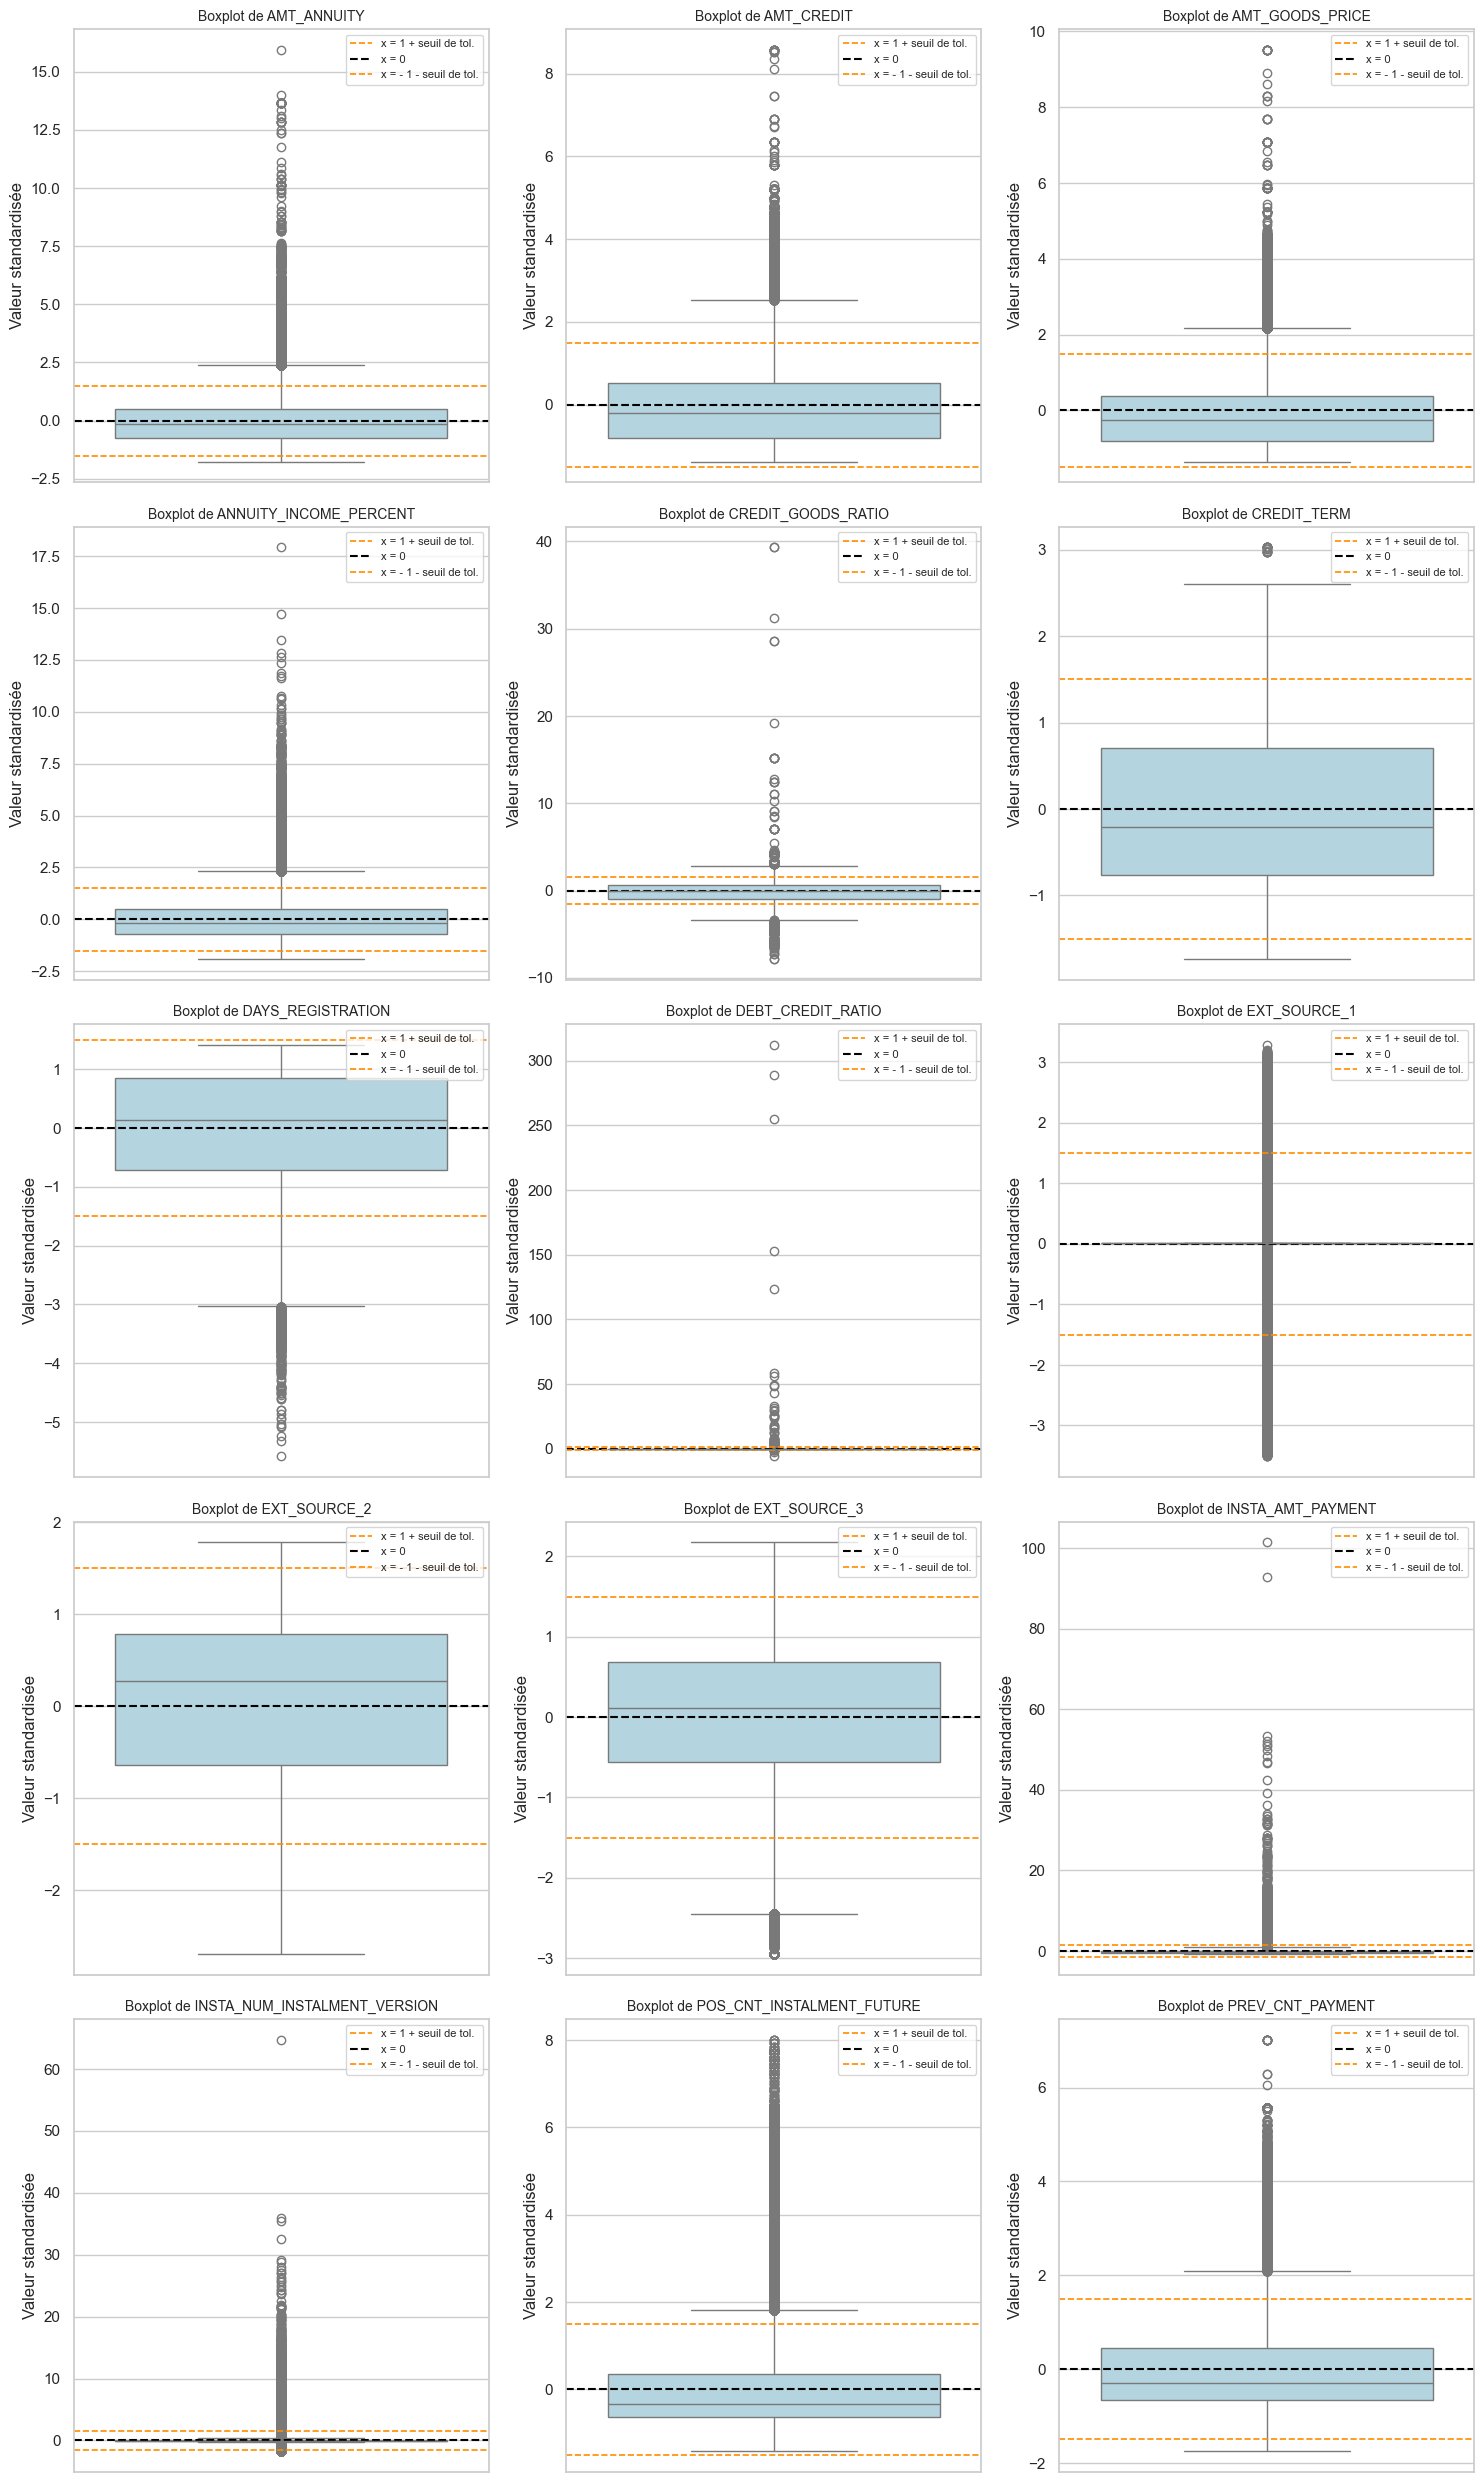

In [26]:
# Vérification des hypothèses de l'ACP - visualisation

# Définir les seuils de tolérance pour l'ACP
tolerance = 0.5  # Tolérance autour de -1 et 1
lower_limit = -1 - tolerance
upper_limit = 1 + tolerance

# Créer un DataFrame avec les données standardisées et les colonnes
data_standardized = pd.DataFrame(dataForPCA_scaled, columns=numCols)

# Création de la figure 5x3
plt.figure(figsize=(15, 25))  # Ajuster la taille pour 5 lignes x 3 colonnes
sns.set_theme(style="whitegrid")

# Itération pour chaque feature normalisée
for i, feature in enumerate(numCols):
    plt.subplot(5, 3, i + 1)

    # Création du boxplot
    sns.boxplot(data=data_standardized, y=feature, color="lightblue")

    # Ajout des lignes pour les hypothèses de l'ACP
    plt.axhline(upper_limit, color='darkorange', linestyle='--', linewidth=1.2, label=f"x = 1 + seuil de tol.")
    plt.axhline(0, color='black', linestyle='--', linewidth=1.5, label="x = 0")
    plt.axhline(lower_limit, color='darkorange', linestyle='--', linewidth=1.2, label=f"x = - 1 - seuil de tol.")

    # Configuration des axes et du titre
    plt.title(f"Boxplot de {feature}", fontsize=10)
    plt.ylabel("Valeur standardisée")
    plt.xlabel("")  # Supprimer le label inutile

    # Légende
    plt.legend(loc='upper right', fontsize=8)

# Ajustement de la mise en page
plt.tight_layout()
plt.show()

In [27]:
# # 📊 PCA avec un nombre de composantes égal au nombre de features
# pca = PCA(n_components=len(numCols))
# pcaRes = pca.fit_transform(dataForPCA_scaled)

# # Création des noms des composantes principales
# pcNames = [f'PC{i+1}' for i in range(len(numCols))]

# # Stockage des résultats dans un DataFrame
# pcaTab = pd.DataFrame(data=pcaRes, columns=pcNames)

# # Affichage des premières lignes
# pcaTab.head()

In [28]:
# # Calcul des variances non cumulées et cumulées
# explained_variance = pca.explained_variance_  # Variance brute
# explained_variance_ratio = pca.explained_variance_ratio_ * 100  # Variance en pourcentage
# cumulative_variance = np.cumsum(explained_variance)  # Variance cumulée brute
# cumulative_variance_ratio = np.cumsum(explained_variance_ratio)  # Variance cumulée en pourcentage

# # Création du DataFrame
# variance_df = pd.DataFrame({
#     "Principal Component": [f"PC{i}" for i in range(1, len(explained_variance) + 1)],
#     "Variance (Brute)": explained_variance,
#     "Cumulative Variance (Brute)": cumulative_variance,
#     "Variance (%)": explained_variance_ratio,
#     "Cumulative Variance (%)": cumulative_variance_ratio
# })

# # Formatage des chiffres (3 chiffres après la virgule)
# variance_df["Variance (Brute)"] = variance_df["Variance (Brute)"].map(lambda x: f"{x:.3f}")
# variance_df["Cumulative Variance (Brute)"] = variance_df["Cumulative Variance (Brute)"].map(lambda x: f"{x:.3f}")
# variance_df["Variance (%)"] = variance_df["Variance (%)"].map(lambda x: f"{x:.3f}")
# variance_df["Cumulative Variance (%)"] = variance_df["Cumulative Variance (%)"].map(lambda x: f"{x:.3f}")

# # Affichage du DataFrame
# variance_df

In [29]:
# # Ajout des projections sur PC1
# df['PC1'] = pcaRes[:, 0]

# plt.figure(figsize=(8, 5))

# # Création du boxplot avec distinction de la variable TARGET
# sns.boxplot(
#     x='TARGET',
#     y='PC1',
#     data=df,
#     showfliers=True,  # Affichage des outliers
#     whis=1.5,  # Définition des valeurs extrêmes via la règle de Tukey
#     hue="TARGET",  # Ajout de la couleur en fonction de TARGET
#     hue_order=[0, 1],  # Ordre des classes
#     palette={0: "blue", 1: "red"}  # Modification des couleurs
# )

# # Titres et labels cohérents avec les autres figures
# plt.title("Projection sur PC1 par classe TARGET")
# plt.xlabel("TARGET")
# plt.ylabel("Projection sur PC1")

# # Ajout de la grille
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Affichage
# plt.show()

# Export des features

In [30]:
# 📌 Définition du chemin du dossier d'export
export_dir = os.path.join(os.getcwd(), "features")

# 📂 Vérification et création du dossier s'il n'existe pas
os.makedirs(export_dir, exist_ok=True)

# 📌 Export des datasets
app_train_path = os.path.join(export_dir, "app_train_features.csv")
app_test_path = os.path.join(export_dir, "app_test_features.csv")

app_train.to_csv(app_train_path, index=False, encoding='utf-8')
app_test.to_csv(app_test_path, index=False, encoding='utf-8')

# ✅ Confirmation
print(f"✅ Fichiers exportés avec succès :\n - {app_train_path}\n - {app_test_path}")

✅ Fichiers exportés avec succès :
 - d:\Pro\OpenClassrooms\Projet_7\3_dossier_code_012025\features\app_train_features.csv
 - d:\Pro\OpenClassrooms\Projet_7\3_dossier_code_012025\features\app_test_features.csv


# Modélisation

## Définitions

In [252]:
def business_metric(y_true, y_pred, cost_fn=5, cost_fp=1):
    """
    Calcule la métrique métier pondérée en fonction des coûts des faux négatifs (FN) et faux positifs (FP).

    Parameters:
    - y_true : array-like, shape (n_samples,) - Labels réels
    - y_pred : array-like, shape (n_samples,) - Prédictions du modèle
    - cost_fn : int - Coût associé aux faux négatifs (par défaut 5)
    - cost_fp : int - Coût associé aux faux positifs (par défaut 1)

    Returns:
    - score métier (float) - Plus le score est proche de 1, meilleure est la performance métier.
    """
    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût pondéré
    total_cost = (cost_fn * fn) + (cost_fp * fp)
    total_predictions = tn + fp + fn + tp

    # Calcul du score métier
    business_score = 1 - (total_cost / total_predictions)

    return business_score

# Création d'un scorer compatible avec GridSearchCV et RandomizedSearchCV
business_scorer = make_scorer(business_metric, greater_is_better=True)

In [253]:
def log_mlflow_results(results, algorithm_name, X_train, experiment_name=None, run_name=None, mlflow_logging=True):
    """
    Enregistre les résultats d'un modèle dans MLFlow avec des vérifications robustes.

    Arguments :
    - results : Dictionnaire contenant les résultats du modèle.
    - algorithm_name : Nom de l'algorithme utilisé.
    - X_train : Données d'entraînement pour générer l'exemple d'entrée.
    - experiment_name : Nom de l'expérience (défini automatiquement si None).
    - run_name : Nom du run (défini automatiquement si None).
    - mlflow_logging : Booléen pour activer ou désactiver le logging MLFlow.
    """
    if not mlflow_logging:
        print("⚠️ MLflow logging désactivé.")
        return

    # 📌 Vérification et correction de l’URI de suivi MLflow
    # tracking_uri = "file:D:/Pro/OpenClassrooms/Projet_7/3_dossier_code_012025/mlruns"
    tracking_uri = "file:D:/Pro/OpenClassrooms/Projet_7/mlruns/"
    if mlflow.get_tracking_uri() != tracking_uri:
        mlflow.set_tracking_uri(tracking_uri)
        print(f"📌 Chemin actuel de suivi MLflow : {mlflow.get_tracking_uri()}")

    # 📂 Vérification de l'existence du dossier MLflow
    # mlruns_path = "D:/Pro/OpenClassrooms/Projet_7/3_dossier_code_012025/mlruns"
    mlruns_path = "D:/Pro/OpenClassrooms/Projet_7/mlruns/"
    if not os.path.exists(mlruns_path):
        print(f"📂 Dossier MLflow inexistant. Création du dossier : {mlruns_path}")
        os.makedirs(mlruns_path)

    # 🔎 Vérification et création de l’expérience MLflow
    if experiment_name is None:
        experiment_name = f"{algorithm_name}_Tracking"

    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        print(f"🛠️ Création d'une nouvelle expérience MLflow : {experiment_name}")
        experiment_id = mlflow.create_experiment(experiment_name)
    else:
        experiment_id = experiment.experiment_id
        print(f"📌 Expérience actuelle MLflow : {experiment}")
        print(f"📌 Liste des expériences disponibles : {mlflow.search_experiments()}")

    mlflow.set_experiment(experiment_name)

    # 📌 Définition d'un nom de run unique
    if run_name is None:
        run_name = f"{algorithm_name}_{results['best_params']}"

    # 🔄 Démarrage du run MLflow
    try:
        with mlflow.start_run(run_name=run_name) as run:
            print(f"🚀 Run MLflow démarré - ID : {run.info.run_id}")
            print(f"📂 Emplacement de stockage du run : {mlflow.get_artifact_uri()}")
            # 🏷️ Log des tags
            mlflow.set_tag("model", algorithm_name)
            mlflow.set_tag("run_name", run_name)
            mlflow.set_tag("experiment_name", experiment_name)

            # 📊 Log des hyperparamètres
            mlflow.log_params(results["best_params"])

            # 📉 Log des métriques de test
            mlflow.log_metric("AUC_test", results["auc_test"])
            mlflow.log_metric("Business_Score_test", results["business_score_test"])

            # 📊 Log des métriques de validation croisée par fold
            if 'cv_scores' in results:
                for i, auc_score in enumerate(results["cv_scores"]["auc"]):
                    mlflow.log_metric(f"AUC_fold_{i+1}", auc_score)
                for i, business_metric in enumerate(results["cv_scores"]["business_metric"]):
                    mlflow.log_metric(f"Business_Metric_fold_{i+1}", business_metric)
                for i, accuracy in enumerate(results["cv_scores"]["accuracy"]):
                    mlflow.log_metric(f"Accuracy_fold_{i+1}", accuracy)

            # 📌 Enregistrement du modèle avec un exemple d'entrée
            model = results["model"]
            example_input = X_train.iloc[0].to_numpy().reshape(1, -1)

            registered_model_name = f"{algorithm_name}_Model"
            mlflow.sklearn.log_model(model, "model", input_example=example_input)
            print(f"✅ Modèle {registered_model_name} loggé dans MLflow !")

            # 📌 Vérification et enregistrement du modèle
            client = MlflowClient()
            try:
                mlflow.register_model(f"runs:/{run.info.run_id}/model", registered_model_name)
                print(f"✅ Modèle '{registered_model_name}' enregistré avec succès !")
            except MlflowException as e:
                if "already exists" in str(e):
                    print(f"⚠️ Modèle '{registered_model_name}' existe déjà, ajout d'une nouvelle version.")
                    mlflow.register_model(f"runs:/{run.info.run_id}/model", registered_model_name)
                else:
                    print(f"❌ Erreur lors de l'enregistrement du modèle : {e}")

    except Exception as e:
        print(f"❌ Erreur critique lors du logging MLflow : {e}")

In [254]:
# # Version fonctionnelle
# def train_and_evaluate(X, y, algorithm, hyperparams, searchMode='grid', numFolds=7,
#                        mlflow_logging=True, balance_strategy=None, refitMetric="business_metric"):
#     """
#     Entraîne un modèle, évalue la performance et logge les résultats dans MLFlow.

#     Parameters:
#     - X (pd.DataFrame): Features du dataset.
#     - y (pd.Series): Labels de la cible.
#     - algorithm: Modèle de machine learning à entraîner.
#     - hyperparams (dict): Dictionnaire des hyperparamètres à tester.
#     - searchMode (str): 'grid' (par défaut) ou 'random' pour RandomizedSearchCV.
#     - numFolds (int): Nombre de folds pour la validation croisée.
#     - mlflow_logging (bool): Active ou désactive le logging MLFlow.
#     - balance_strategy (str): Méthode de gestion du déséquilibre des classes ('SMOTE', 'class_weight', 'undersampling' ou None).
#     - refitMetric (str): Métrique utilisée pour sélectionner le meilleur modèle.

#     Returns:
#     - dict: Résultats d'évaluation incluant le modèle entraîné, les métriques et les scores SHAP.
#     """

#     # 🚨 Vérification des entrées
#     if not isinstance(X, pd.DataFrame) or not isinstance(y, pd.Series):
#         raise ValueError("X doit être un DataFrame et y doit être une Series")
#     if not isinstance(hyperparams, dict):
#         raise ValueError("hyperparams doit être un dictionnaire")

#     # 🎯 Split train/test (Stratification pour préserver la distribution des classes)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/numFolds, random_state=42, stratify=y)

#     # 🔄 Gestion des valeurs manquantes & standardisation pour LogisticRegression uniquement
#     if isinstance(algorithm, LogisticRegression):
#         X_train = X_train.fillna(X_train.median())
#         X_test = X_test.fillna(X_test.median())
#         scaler = StandardScaler()
#         X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
#         X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

#     # 🎯 Imputation des NaN uniquement si SMOTE + LightGBM
#     if balance_strategy == "SMOTE" and isinstance(algorithm, LGBMClassifier):
#         nan_count = X_train.isna().sum().sum()
#         if nan_count > 0:
#             print(f"⚠️ {nan_count} NaN détectés dans X_train avec SMOTE et LightGBM. Imputation en cours...")
#             imputer = SimpleImputer(strategy="median")
#             X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns, index=X_train.index)
#             X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns, index=X_test.index)

#     # 🎯 Gestion des classes déséquilibrées via Pipeline
#     sampler = None
#     if balance_strategy == "SMOTE":
#         sampler = SMOTE(random_state=42)
#     elif balance_strategy == "undersampling":
#         sampler = RandomUnderSampler(random_state=42)

#     # Création du pipeline pour appliquer l’échantillonnage pendant la validation croisée
#     if sampler:
#         pipeline = Pipeline([
#             ('sampler', sampler),
#             ('classifier', algorithm)
#         ], memory='D:/Pro/OpenClassrooms/Projet_7/cache')
#     else:
#         pipeline = algorithm

#     # 🔢 Définition du scoring
#     scoring = {
#         'business_metric': business_scorer,
#         'auc': 'roc_auc',
#         'accuracy': 'accuracy'
#     }

#     # ⏳ Sélection de la méthode de recherche d'hyperparamètres
#     start_time = time.time()
#     if searchMode == 'grid':
#         search = GridSearchCV(pipeline, hyperparams, scoring=scoring, refit=refitMetric, cv=numFolds, n_jobs=-1)
#     else:
#         search = RandomizedSearchCV(pipeline, hyperparams, scoring=scoring, refit=refitMetric, cv=numFolds, n_iter=10, random_state=42, n_jobs=-1)

#     # ✅ Test rapide du modèle avant GridSearch pour éviter un crash total
#     try:
#         algorithm.fit(X_train, y_train)
#         print("✅ Modèle entraîné avec succès sur un échantillon.")
#     except Exception as e:
#         print(f"❌ Erreur lors du test d'entraînement avant GridSearch : {e}")
#         return None

#     # 🏋️‍♂️ Entraînement du modèle avec GridSearch
#     try:
#         search.fit(X_train, y_train)
#     except Exception as e:
#         print(f"⚠️ Erreur lors de l'entraînement avec LightGBM : {e}")
#         return None
#     search_time = time.time() - start_time

#     # 📊 Vérification de `cv_results_`
#     if not hasattr(search, "cv_results_"):
#         print("❌ Échec total de GridSearch. Vérifiez les données et les hyperparamètres.")
#         return None

#     # 📊 Extraction des scores de validation croisée
#     cv_results = search.cv_results_
#     cv_scores = {
#         "auc": [cv_results[f'split{i}_test_auc'][0] for i in range(numFolds)],
#         "business_metric": [cv_results[f'split{i}_test_business_metric'][0] for i in range(numFolds)],
#         "accuracy": [cv_results[f'split{i}_test_accuracy'][0] for i in range(numFolds)]
#     }

#     # 📊 Entraînement du modèle final avec les meilleurs hyperparamètres
#     best_model = search.best_estimator_
#     train_start_time = time.time()
#     if isinstance(best_model, Pipeline):
#         best_model = best_model.named_steps['classifier']

#     # 🛠 Feature Importance (SHAP uniquement pour modèles compatibles)
#     shap_values, shap_time = None, None
#     if not isinstance(best_model, DummyClassifier):
#         try:
#             start_shap_time = time.time()

#             if "lightgbm" in str(type(best_model)).lower():
#                 explainer = shap.TreeExplainer(best_model)
#                 shap_values = explainer.shap_values(X_train)
#             else:
#                 explainer = shap.Explainer(best_model, X_train)
#                 shap_values = explainer(X_train).values

#             shap_time = time.time() - start_shap_time
#             print(f"✅ SHAP importance calculée en {shap_time:.3f} sec")

#         except Exception as e:
#             print(f"⚠️ Erreur SHAP ignorée pour {best_model.__class__.__name__}: {e}")

#     # Temps d'entraînement
#     train_time = time.time() - train_start_time

#     # 📊 Calcul de la matrice de confusion (sur le jeu de test)
#     conf_matrix = confusion_matrix(y_test, best_model.predict(X_test))
#     confusion_data = {
#         "matrix": conf_matrix.tolist(),  # Convertir en liste pour éviter des erreurs NumPy
#         "labels": ["Bon client (0)", "Mauvais client (1)"],  # Labels des classes
#         "class_counts": {
#             "TN": int(conf_matrix[0, 0]), "FP": int(conf_matrix[0, 1]),
#             "FN": int(conf_matrix[1, 0]), "TP": int(conf_matrix[1, 1])
#         }
#     }

#     # Compilation des résultats
#     results = {
#         "model": best_model,
#         "best_params": search.best_params_,
#         "search_time": search_time,
#         "train_time": train_time,
#         "shap_time": shap_time,
#         "auc_test": roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]) if hasattr(best_model, "predict_proba") else None,
#         "business_score_test": business_metric(y_test, best_model.predict(X_test)),
#         "cv_scores": cv_scores,
#         "feature_importance": {
#             "shap_values": shap_values if isinstance(shap_values, np.ndarray) else (shap_values.values if shap_values is not None else None),
#             "base_values": None if isinstance(shap_values, np.ndarray) else (shap_values.base_values if shap_values is not None else None),
#             "feature_names": list(X_train.columns) if shap_values is not None else None,
#             "data": X_train if shap_values is not None else None,
#         },
#         "y_pred_test": best_model.predict(X_test),
#         "y_pred_train": best_model.predict(X_train),
#         "confusion_matrix": confusion_data
#     }

#     log_mlflow_results(results, algorithm.__class__.__name__, X_train)
#     return results

In [295]:

def train_and_evaluate(X, y, algorithm, hyperparams, searchMode='grid', numFolds=7,
                       mlflow_logging=True, balance_strategy=None, refitMetric="business_metric"):
    """
    Entraîne un modèle, évalue la performance et logge les résultats dans MLFlow.

    Parameters:
    - X (pd.DataFrame): Features du dataset.
    - y (pd.Series): Labels de la cible.
    - algorithm: Modèle de machine learning à entraîner.
    - hyperparams (dict): Dictionnaire des hyperparamètres à tester.
    - searchMode (str): 'grid' (par défaut) ou 'random' pour RandomizedSearchCV.
    - numFolds (int): Nombre de folds pour la validation croisée.
    - mlflow_logging (bool): Active ou désactive le logging MLFlow.
    - balance_strategy (str): Méthode de gestion du déséquilibre des classes ('SMOTE', 'class_weight', 'undersampling' ou None).
    - refitMetric (str): Métrique utilisée pour sélectionner le meilleur modèle.

    Returns:
    - dict: Résultats d'évaluation incluant le modèle entraîné, les métriques et les scores SHAP.
    """

    # 🚨 Vérification des entrées
    if not isinstance(X, pd.DataFrame) or not isinstance(y, pd.Series):
        raise ValueError("X doit être un DataFrame et y doit être une Series")
    if not isinstance(hyperparams, dict):
        raise ValueError("hyperparams doit être un dictionnaire")

    # 📌 Définition des jeux finaux (utilisés pour l’optimisation du seuil de probabilités)
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # ✅ Imputation des NaN uniquement pour les modèles qui ne les supportent pas
    if not isinstance(algorithm, LGBMClassifier) or balance_strategy == "SMOTE":
        print("🚀 Imputation des NaN en cours...")
        imputer = SimpleImputer(strategy="median")

        # Appliquer sur l’ensemble des données avant le split en validation croisée
        X_train_final = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)
        X_test_final = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

        # ✅ Vérification des NaN après imputation
        print(f"✅ Après imputation - NaN dans X_train_final : {X_train_final.isna().sum().sum()}")
        print(f"✅ Après imputation - NaN dans X_test_final : {X_test_final.isna().sum().sum()}")

    # 🎯 Split validation croisée (sans inclure les jeux finaux)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_final, y_train_final, test_size=1/numFolds, random_state=42, stratify=y_train_final
    )

    # 🔄 Imputation également sur `X_train` et `X_val`
    if not isinstance(algorithm, LGBMClassifier) or balance_strategy == "SMOTE":
        X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
        X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

        # ✅ Vérification des NaN après imputation
        print(f"✅ Après imputation - NaN dans X_train : {X_train.isna().sum().sum()}")
        print(f"✅ Après imputation - NaN dans X_val : {X_val.isna().sum().sum()}")

    # 🌟 Standardisation après imputation (LogisticRegression uniquement)
    if isinstance(algorithm, LogisticRegression):
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
        X_test_final = pd.DataFrame(scaler.transform(X_test_final), columns=X_test_final.columns)

    # 🎯 Imputation des NaN si SMOTE utilisé avec LightGBM
    if balance_strategy == "SMOTE" and isinstance(algorithm, LGBMClassifier):
        nan_count = X_train.isna().sum().sum()
        if nan_count > 0:
            print(f"⚠️ {nan_count} NaN détectés dans X_train avec SMOTE et LightGBM. Imputation en cours...")
            imputer = SimpleImputer(strategy="median")
            X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns, index=X_train.index)
            X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns, index=X_test.index)

    # 🎯 Gestion des classes déséquilibrées via Pipeline
    sampler = None
    if balance_strategy == "SMOTE":
        sampler = SMOTE(random_state=42)
    elif balance_strategy == "undersampling":
        sampler = RandomUnderSampler(random_state=42)

    # Création du pipeline pour appliquer l’échantillonnage pendant la validation croisée
    if sampler:
        pipeline = Pipeline([
            ('sampler', sampler),
            ('classifier', algorithm)
        ], memory='D:/Pro/OpenClassrooms/Projet_7/cache')
    else:
        pipeline = algorithm

    # 🔢 Définition du scoring
    scoring = {
        'business_metric': business_scorer,
        'auc': 'roc_auc',
        'accuracy': 'accuracy'
    }

    # ⏳ Sélection de la méthode de recherche d'hyperparamètres
    start_time = time.time()
    if searchMode == 'grid':
        search = GridSearchCV(pipeline, hyperparams, scoring=scoring, refit=refitMetric, cv=numFolds, n_jobs=-1)
    else:
        search = RandomizedSearchCV(pipeline, hyperparams, scoring=scoring, refit=refitMetric, cv=numFolds, n_iter=10, random_state=42, n_jobs=-1)

    # ✅ Test rapide du modèle avant GridSearch pour éviter un crash
    try:
        algorithm.fit(X_train, y_train)
        print("✅ Modèle entraîné avec succès sur un échantillon.")
    except Exception as e:
        print(f"❌ Erreur lors du test d'entraînement avant GridSearch : {e}")
        return None

    # 🏋️‍♂️ Entraînement du modèle avec GridSearch
    try:
        search.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ Erreur lors de l'entraînement avec LightGBM : {e}")
        return None
    search_time = time.time() - start_time

    # 📊 Vérification de `cv_results_`
    if not hasattr(search, "cv_results_"):
        print("❌ Échec total de GridSearch. Vérifiez les données et les hyperparamètres.")
        return None

    # 📊 Extraction des scores de validation croisée
    cv_results = search.cv_results_
    cv_scores = {
        "auc": [cv_results[f'split{i}_test_auc'][0] for i in range(numFolds)],
        "business_metric": [cv_results[f'split{i}_test_business_metric'][0] for i in range(numFolds)],
        "accuracy": [cv_results[f'split{i}_test_accuracy'][0] for i in range(numFolds)]
    }

    # 📊 Entraînement du modèle final avec les meilleurs hyperparamètres
    best_model = search.best_estimator_
    train_start_time = time.time()
    if isinstance(best_model, Pipeline):
        best_model = best_model.named_steps['classifier']

    # 🛠 Feature Importance (SHAP uniquement pour modèles compatibles)
    shap_values, shap_time = None, None
    if not isinstance(best_model, DummyClassifier):
        try:
            start_shap_time = time.time()

            # 🔍 Limiter SHAP à un échantillon de 5000 lignes max pour accélérer le calcul
            sample_shap = X_train_final if len(X_train_final) < 5000 else X_train_final.sample(5000, random_state=42)

            if "lightgbm" in str(type(best_model)).lower():
                explainer = shap.TreeExplainer(best_model)
                shap_values = explainer.shap_values(sample_shap)
                shap_values = shap_values[1] if isinstance(shap_values, list) else shap_values  # Cas binaire
            else:
                explainer = shap.Explainer(best_model, sample_shap)
                shap_values = explainer(sample_shap).values

            shap_time = time.time() - start_shap_time
            print(f"✅ SHAP importance calculée en {shap_time:.3f} sec")

        except Exception as e:
            print(f"⚠️ Erreur SHAP ignorée pour {best_model.__class__.__name__}: {e}")

    # Temps d'entraînement
    train_time = time.time() - train_start_time

    # 📊 Calcul de la matrice de confusion (sur le jeu de test)
    conf_matrix = confusion_matrix(y_test_final, best_model.predict(X_test_final))
    confusion_data = {
        "matrix": conf_matrix.tolist(),  # Convertir en liste pour éviter des erreurs NumPy
        "labels": ["Bon client (0)", "Mauvais client (1)"],  # Labels des classes
        "class_counts": {
            "TN": int(conf_matrix[0, 0]), "FP": int(conf_matrix[0, 1]),
            "FN": int(conf_matrix[1, 0]), "TP": int(conf_matrix[1, 1])
        }
    }

    # Compilation des résultats
    results = {
        "model": best_model,
        "best_params": search.best_params_,
        "search_time": search_time,
        "train_time": train_time,
        "shap_time": shap_time,
        "auc_test": roc_auc_score(y_test_final, best_model.predict_proba(X_test_final)[:, 1]) if hasattr(best_model, "predict_proba") else None,
        "business_score_test": business_metric(y_test_final, best_model.predict(X_test_final)),
        "cv_scores": cv_scores,
        "feature_importance": {
            "shap_values": shap_values if isinstance(shap_values, np.ndarray) else (shap_values.values if shap_values is not None else None),
            "base_values": None if isinstance(shap_values, np.ndarray) else (shap_values.base_values if shap_values is not None else None),
            "feature_names": list(X_train.columns) if shap_values is not None else None,
            "data": X_train if shap_values is not None else None,
        },
        "X_test_final": X_test_final,
        "y_test_final": y_test_final,
        "y_pred_test": best_model.predict(X_test_final),
        "y_pred_train": best_model.predict(X_train_final),
        "confusion_matrix": confusion_data
    }

    log_mlflow_results(results, algorithm.__class__.__name__, X_train)
    return results

In [256]:
def display_results(results):
    """
    Affiche un aperçu structuré des résultats du modèle, incluant les hyperparamètres,
    les scores de validation croisée, les métriques d'évaluation et les temps d'exécution.

    Arguments:
    - results (dict) : Dictionnaire contenant les résultats du modèle.
    """
    if not results or not isinstance(results, dict):
        print("⚠️ Aucun résultat disponible. Assurez-vous que le dictionnaire 'results' est défini et contient des données.")
        return

    print(f"🔹 Meilleurs hyperparamètres : {results['best_params']}")
    print(f"⏳ Temps d'optimisation des hyperparamètres : {results['search_time']:.3f} sec")
    print(f"⏳ Temps d'entraînement du meilleur modèle : {results['train_time']:.3f} sec")
    print(f"📊 AUC Test : {results['auc_test']:.3f}")
    print(f"💰 Business Score Test : {results['business_score_test']:.3f}")
    print(f"📈 Accuracy Test : {np.mean(results['cv_scores']['accuracy']):.3f}")

    # Scores de validation croisée par folds
    if 'cv_scores' in results:
        print("\n📊 Scores de validation croisée par folds :")

        # Création du DataFrame des scores
        cv_scores_df = pd.DataFrame({
            'Fold': [f'Fold {i+1}' for i in range(len(results['cv_scores']['auc']))] + ['Moy', 'Écart-T'],
            'AUC': results['cv_scores']['auc'] + [np.mean(results['cv_scores']['auc']), np.std(results['cv_scores']['auc'])],
            'BMetric': results['cv_scores']['business_metric'] + [np.mean(results['cv_scores']['business_metric']), np.std(results['cv_scores']['business_metric'])],
            'Acc': results['cv_scores']['accuracy'] + [np.mean(results['cv_scores']['accuracy']), np.std(results['cv_scores']['accuracy'])]
        })

        # Affichage propre avec tabulate (sans index)
        print(tabulate(cv_scores_df, headers='keys', tablefmt='fancy_grid', showindex=False))

    # Résultats de SHAP
    if 'feature_importance' in results and results['feature_importance']["shap_values"] is not None:
        print("\n📊 Feature Importance avec SHAP :")
        print(f"⏳ Temps d'évaluation SHAP : {results['shap_time']:.3f} sec")

        # Calcul des valeurs absolues moyennes pour obtenir l'importance des features
        shap_values = np.abs(results['feature_importance']["shap_values"]).mean(axis=0)
        feature_names = results['feature_importance']["feature_names"]

        # Création d'un DataFrame pour trier les features par importance
        shap_importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Mean |SHAP value|": shap_values
        }).sort_values(by="Mean |SHAP value|", ascending=False).head(10)

        # 10 features les plus importantes
        print("\n📌 Top 10 Features les plus influentes selon SHAP :")
        print(tabulate(shap_importance_df, headers='keys', tablefmt='fancy_grid'))

    # 📊 Affichage de la matrice de confusion sous forme de tableau structuré
    if "confusion_matrix" in results:
        print("\n📊 Matrice de confusion :")

        try:
            conf_matrix = np.array(results["confusion_matrix"]["matrix"], dtype=int)
            labels = results["confusion_matrix"]["labels"]
            class_counts = results["confusion_matrix"]["class_counts"]

            if conf_matrix.shape == (2, 2):  # Vérification que la matrice est bien de taille 2x2
                conf_table = [
                    ["", f"Prédit : {labels[0]}", f"Prédit : {labels[1]}"],
                    [f"Réel : {labels[0]}", conf_matrix[0, 0], conf_matrix[0, 1]],
                    [f"Réel : {labels[1]}", conf_matrix[1, 0], conf_matrix[1, 1]]
                ]

                print(tabulate(conf_table, tablefmt="fancy_grid"))

                # Affichage des valeurs exactes de la matrice
                print("\n📌 Détails des classes :")
                details_table = [
                    ["Vrais Négatifs (TN)", class_counts["TN"]],
                    ["Faux Positifs (FP)", class_counts["FP"]],
                    ["Faux Négatifs (FN)", class_counts["FN"]],
                    ["Vrais Positifs (TP)", class_counts["TP"]],
                ]

                print(tabulate(details_table, tablefmt="fancy_grid"))

            else:
                print("⚠️ Erreur : La matrice de confusion n'a pas la forme attendue (2x2).")

        except Exception as e:
            print(f"❌ Erreur lors de l'affichage de la matrice de confusion : {e}")

    print("\n")

In [257]:
# 🎯 Définition des jeux de données
X_train_full = app_train.drop(columns=["SK_ID_CURR", "TARGET"])  # Suppression de l'ID et de la cible
y_train_full = app_train["TARGET"]  # Définition de la variable cible
X_test_final = app_test.drop(columns=["SK_ID_CURR"])

## Dummy Classifier

In [296]:
dummy_params = {'strategy': ['most_frequent', 'prior']}
results_dummy = train_and_evaluate(
    X_train_full, y_train_full, DummyClassifier(), dummy_params, searchMode='grid', mlflow_logging=True
)

🚀 Imputation des NaN en cours...
✅ Après imputation - NaN dans X_train_final : 0
✅ Après imputation - NaN dans X_test_final : 0
✅ Après imputation - NaN dans X_train : 0
✅ Après imputation - NaN dans X_val : 0
✅ Modèle entraîné avec succès sur un échantillon.
📌 Expérience actuelle MLflow : <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/733426006280992044', creation_time=1738489820087, experiment_id='733426006280992044', last_update_time=1738489820087, lifecycle_stage='active', name='DummyClassifier_Tracking', tags={}>
📌 Liste des expériences disponibles : [<Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/638921222916288549', creation_time=1738513334771, experiment_id='638921222916288549', last_update_time=1738513334771, lifecycle_stage='active', name='LGBMClassifier_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/121289714041008416', creation_time=1738506880430, experiment_id='12128971

✅ Modèle DummyClassifier_Model loggé dans MLflow !
✅ Modèle 'DummyClassifier_Model' enregistré avec succès !


Registered model 'DummyClassifier_Model' already exists. Creating a new version of this model...
Created version '11' of model 'DummyClassifier_Model'.


In [297]:
display_results(results_dummy)

🔹 Meilleurs hyperparamètres : {'strategy': 'most_frequent'}
⏳ Temps d'optimisation des hyperparamètres : 3.122 sec
⏳ Temps d'entraînement du meilleur modèle : 0.000 sec
📊 AUC Test : 0.500
💰 Business Score Test : 0.596
📈 Accuracy Test : 0.919

📊 Scores de validation croisée par folds :
╒═════════╤═══════╤═════════════╤═════════════╕
│ Fold    │   AUC │     BMetric │         Acc │
╞═════════╪═══════╪═════════════╪═════════════╡
│ Fold 1  │   0.5 │ 0.596338    │ 0.919268    │
├─────────┼───────┼─────────────┼─────────────┤
│ Fold 2  │   0.5 │ 0.596482    │ 0.919296    │
├─────────┼───────┼─────────────┼─────────────┤
│ Fold 3  │   0.5 │ 0.596326    │ 0.919265    │
├─────────┼───────┼─────────────┼─────────────┤
│ Fold 4  │   0.5 │ 0.596326    │ 0.919265    │
├─────────┼───────┼─────────────┼─────────────┤
│ Fold 5  │   0.5 │ 0.596326    │ 0.919265    │
├─────────┼───────┼─────────────┼─────────────┤
│ Fold 6  │   0.5 │ 0.596326    │ 0.919265    │
├─────────┼───────┼─────────────┼─────────

## Régression logistique

In [298]:
logreg_params = {
    'C': np.logspace(-3, 3, 7),
    "penalty": ["l1", "l2"],
    "fit_intercept": [True, False],
    'solver': ['liblinear']
}

In [299]:
results_logreg = train_and_evaluate(
    X_train_full, y_train_full, LogisticRegression(random_state=42, max_iter=500),
    logreg_params, searchMode='grid', mlflow_logging=True, balance_strategy=None
)

🚀 Imputation des NaN en cours...
✅ Après imputation - NaN dans X_train_final : 0
✅ Après imputation - NaN dans X_test_final : 0
✅ Après imputation - NaN dans X_train : 0
✅ Après imputation - NaN dans X_val : 0
✅ Modèle entraîné avec succès sur un échantillon.
✅ SHAP importance calculée en 0.257 sec
📌 Expérience actuelle MLflow : <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/121289714041008416', creation_time=1738506880430, experiment_id='121289714041008416', last_update_time=1738506880430, lifecycle_stage='active', name='LogisticRegression_Tracking', tags={}>
📌 Liste des expériences disponibles : [<Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/638921222916288549', creation_time=1738513334771, experiment_id='638921222916288549', last_update_time=1738513334771, lifecycle_stage='active', name='LGBMClassifier_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/121289714041008416', creation_

d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(

✅ Modèle LogisticRegression_Model loggé dans MLflow !
✅ Modèle 'LogisticRegression_Model' enregistré avec succès !



d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
Registered model 'LogisticRegression_Model' already exists. Creating a new version of this model...
Created version '10' of model 'LogisticRegression_Model'.


In [300]:
display_results(results_logreg)

🔹 Meilleurs hyperparamètres : {'C': np.float64(1.0), 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
⏳ Temps d'optimisation des hyperparamètres : 432.273 sec
⏳ Temps d'entraînement du meilleur modèle : 0.257 sec
📊 AUC Test : 0.734
💰 Business Score Test : 0.600
📈 Accuracy Test : 0.919

📊 Scores de validation croisée par folds :
╒═════════╤════════════╤═════════════╤═════════════╕
│ Fold    │        AUC │     BMetric │         Acc │
╞═════════╪════════════╪═════════════╪═════════════╡
│ Fold 1  │ 0.729518   │ 0.596619    │ 0.919299    │
├─────────┼────────────┼─────────────┼─────────────┤
│ Fold 2  │ 0.722826   │ 0.596701    │ 0.919265    │
├─────────┼────────────┼─────────────┼─────────────┤
│ Fold 3  │ 0.723212   │ 0.596513    │ 0.919203    │
├─────────┼────────────┼─────────────┼─────────────┤
│ Fold 4  │ 0.719353   │ 0.596607    │ 0.919296    │
├─────────┼────────────┼─────────────┼─────────────┤
│ Fold 5  │ 0.729386   │ 0.596482    │ 0.919296    │
├─────────┼─────────

In [301]:
logreg_params_pipeline = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ["l1", "l2"],
    'classifier__fit_intercept': [True, False],
    'classifier__solver': ['liblinear']
}

In [302]:
results_logreg_sm = train_and_evaluate(
    X_train_full, y_train_full, LogisticRegression(random_state=42, max_iter=500),
    logreg_params_pipeline, searchMode='grid', mlflow_logging=True, balance_strategy='SMOTE'
)

🚀 Imputation des NaN en cours...
✅ Après imputation - NaN dans X_train_final : 0
✅ Après imputation - NaN dans X_test_final : 0
✅ Après imputation - NaN dans X_train : 0
✅ Après imputation - NaN dans X_val : 0
✅ Modèle entraîné avec succès sur un échantillon.


d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\joblib\memory.py:577: UserWarning: Persisting input arguments took 0.73s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


✅ SHAP importance calculée en 0.353 sec
📌 Expérience actuelle MLflow : <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/121289714041008416', creation_time=1738506880430, experiment_id='121289714041008416', last_update_time=1738506880430, lifecycle_stage='active', name='LogisticRegression_Tracking', tags={}>
📌 Liste des expériences disponibles : [<Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/638921222916288549', creation_time=1738513334771, experiment_id='638921222916288549', last_update_time=1738513334771, lifecycle_stage='active', name='LGBMClassifier_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/121289714041008416', creation_time=1738506880430, experiment_id='121289714041008416', last_update_time=1738506880430, lifecycle_stage='active', name='LogisticRegression_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/733426006280992044', crea

d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Modèle LogisticRegression_Model loggé dans MLflow !
✅ Modèle 'LogisticRegression_Model' enregistré avec succès !


Registered model 'LogisticRegression_Model' already exists. Creating a new version of this model...
Created version '11' of model 'LogisticRegression_Model'.


In [303]:
display_results(results_logreg_sm)

🔹 Meilleurs hyperparamètres : {'classifier__C': np.float64(10.0), 'classifier__fit_intercept': True, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
⏳ Temps d'optimisation des hyperparamètres : 1185.596 sec
⏳ Temps d'entraînement du meilleur modèle : 0.353 sec
📊 AUC Test : 0.734
💰 Business Score Test : 0.573
📈 Accuracy Test : 0.677

📊 Scores de validation croisée par folds :
╒═════════╤════════════╤═══════════╤════════════╕
│ Fold    │        AUC │   BMetric │        Acc │
╞═════════╪════════════╪═══════════╪════════════╡
│ Fold 1  │ 0.735819   │ 0.575218  │ 0.68207    │
├─────────┼────────────┼───────────┼────────────┤
│ Fold 2  │ 0.727778   │ 0.559551  │ 0.668031   │
├─────────┼────────────┼───────────┼────────────┤
│ Fold 3  │ 0.727765   │ 0.565175  │ 0.676029   │
├─────────┼────────────┼───────────┼────────────┤
│ Fold 4  │ 0.726051   │ 0.56227   │ 0.677248   │
├─────────┼────────────┼───────────┼────────────┤
│ Fold 5  │ 0.734958   │ 0.570674  │ 0.676904   │
├─────

In [304]:
results_logreg_us = train_and_evaluate(
    X_train_full, y_train_full, LogisticRegression(random_state=42, max_iter=500),
    logreg_params_pipeline, searchMode='grid', mlflow_logging=True, balance_strategy='undersampling'
)

🚀 Imputation des NaN en cours...
✅ Après imputation - NaN dans X_train_final : 0
✅ Après imputation - NaN dans X_test_final : 0
✅ Après imputation - NaN dans X_train : 0
✅ Après imputation - NaN dans X_val : 0
✅ Modèle entraîné avec succès sur un échantillon.
✅ SHAP importance calculée en 0.270 sec
📌 Expérience actuelle MLflow : <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/121289714041008416', creation_time=1738506880430, experiment_id='121289714041008416', last_update_time=1738506880430, lifecycle_stage='active', name='LogisticRegression_Tracking', tags={}>
📌 Liste des expériences disponibles : [<Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/638921222916288549', creation_time=1738513334771, experiment_id='638921222916288549', last_update_time=1738513334771, lifecycle_stage='active', name='LGBMClassifier_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/121289714041008416', creation_

d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Modèle LogisticRegression_Model loggé dans MLflow !
✅ Modèle 'LogisticRegression_Model' enregistré avec succès !


d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
Registered model 'LogisticRegression_Model' already exists. Creating a new version of this model...
Created version '12' of model 'LogisticRegression_Model'.


In [305]:
display_results(results_logreg_us)

🔹 Meilleurs hyperparamètres : {'classifier__C': np.float64(1000.0), 'classifier__fit_intercept': True, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
⏳ Temps d'optimisation des hyperparamètres : 23.435 sec
⏳ Temps d'entraînement du meilleur modèle : 0.270 sec
📊 AUC Test : 0.734
💰 Business Score Test : 0.574
📈 Accuracy Test : 0.603

📊 Scores de validation croisée par folds :
╒═════════╤════════════╤════════════╤════════════╕
│ Fold    │        AUC │    BMetric │        Acc │
╞═════════╪════════════╪════════════╪════════════╡
│ Fold 1  │ 0.724857   │ 0.517106   │ 0.604836   │
├─────────┼────────────┼────────────┼────────────┤
│ Fold 2  │ 0.717974   │ 0.505686   │ 0.59442    │
├─────────┼────────────┼────────────┼────────────┤
│ Fold 3  │ 0.7179     │ 0.512998   │ 0.603856   │
├─────────┼────────────┼────────────┼────────────┤
│ Fold 4  │ 0.713654   │ 0.510967   │ 0.604324   │
├─────────┼────────────┼────────────┼────────────┤
│ Fold 5  │ 0.723274   │ 0.514216   │ 0.60032

## Random Forest

In [306]:
# test du modèle uniquement avec undersampling car trop lent

In [307]:
# rf_params = {
#     'n_estimators': [100, 250, 500],  # Progression cohérente
#     'min_samples_leaf': [1, 3, 5],  # Granularité fine sans être trop contraignant
#     'max_features': ['sqrt', 'log2'],  # Permet d'éviter le surajustement tout en testant une bonne diversité
#     'max_depth': [None, 10, 20],
#     'bootstrap': [True, False]
# }

In [308]:
# results_rf = train_and_evaluate(
#     X_train_full, y_train_full, RandomForestClassifier(random_state=42, n_jobs=-1, verbose=1),
#     rf_params, searchMode='grid', numFolds=5, mlflow_logging=True, balance_strategy=None
# )

In [309]:
# display_results(results_rf)

In [310]:
# rf_params_pipeline = {
#     'classifier__n_estimators': [100, 250, 500],  # Progression cohérente
#     'classifier__min_samples_leaf': [1, 3, 5],  # Granularité fine sans être trop contraignant
#     'classifier__max_features': ['sqrt', 'log2'],  # Permet d'éviter le surajustement tout en testant une bonne diversité
#     'classifier__max_depth': [None, 10, 20],
#     'classifier__bootstrap': [True, False]
# }

In [311]:
# results_rf_sm = train_and_evaluate(
#     X_train_full, y_train_full, RandomForestClassifier(random_state=42, n_jobs=-1, verbose=1),
#     rf_params_pipeline, searchMode='grid', numFolds=5, mlflow_logging=True, balance_strategy='SMOTE'
# )

In [312]:
# display_results(results_rf_sm)

In [313]:
# results_rf_us = train_and_evaluate(
#     X_train_full, y_train_full, RandomForestClassifier(random_state=42, n_jobs=-1, verbose=1),
#     rf_params_pipeline, searchMode='grid', numFolds=5, mlflow_logging=True, balance_strategy='undersampling'
# )

In [314]:
# display_results(results_rf_us)

## LightGBM

In [315]:
lgbm_params = {
    'n_estimators': [80, 120, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'num_leaves': [7, 10, 15],
    'reg_alpha': [0, 0.1, 0.3, 0.7],  # Réduction des valeurs extrêmes pour affiner l'effet de la régularisation
    'learning_rate': [0.01, 0.05, 0.1],  # Tester différentes vitesses d’apprentissage
    'colsample_bytree': [0.7, 0.9, 1.0]  # Effet de la sous-sélection des features
}

In [316]:
results_lgbm = train_and_evaluate(
    X_train_full, y_train_full, LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    lgbm_params, searchMode='grid', mlflow_logging=True, balance_strategy=None
)

✅ Modèle entraîné avec succès sur un échantillon.


d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


✅ SHAP importance calculée en 0.989 sec
📌 Expérience actuelle MLflow : <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/638921222916288549', creation_time=1738513334771, experiment_id='638921222916288549', last_update_time=1738513334771, lifecycle_stage='active', name='LGBMClassifier_Tracking', tags={}>
📌 Liste des expériences disponibles : [<Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/638921222916288549', creation_time=1738513334771, experiment_id='638921222916288549', last_update_time=1738513334771, lifecycle_stage='active', name='LGBMClassifier_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/121289714041008416', creation_time=1738506880430, experiment_id='121289714041008416', last_update_time=1738506880430, lifecycle_stage='active', name='LogisticRegression_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/733426006280992044', creation

d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Modèle LGBMClassifier_Model loggé dans MLflow !
✅ Modèle 'LGBMClassifier_Model' enregistré avec succès !


Registered model 'LGBMClassifier_Model' already exists. Creating a new version of this model...
Created version '5' of model 'LGBMClassifier_Model'.


In [317]:
display_results(results_lgbm)

🔹 Meilleurs hyperparamètres : {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 15, 'reg_alpha': 0.7}
⏳ Temps d'optimisation des hyperparamètres : 6232.616 sec
⏳ Temps d'entraînement du meilleur modèle : 0.989 sec
📊 AUC Test : 0.768
💰 Business Score Test : 0.605
📈 Accuracy Test : 0.919

📊 Scores de validation croisée par folds :
╒═════════╤════════════╤═════════════╤═════════════╕
│ Fold    │        AUC │     BMetric │         Acc │
╞═════════╪════════════╪═════════════╪═════════════╡
│ Fold 1  │ 0.721786   │ 0.596338    │ 0.919268    │
├─────────┼────────────┼─────────────┼─────────────┤
│ Fold 2  │ 0.718985   │ 0.596482    │ 0.919296    │
├─────────┼────────────┼─────────────┼─────────────┤
│ Fold 3  │ 0.719067   │ 0.596326    │ 0.919265    │
├─────────┼────────────┼─────────────┼─────────────┤
│ Fold 4  │ 0.718699   │ 0.596326    │ 0.919265    │
├─────────┼────────────┼─────────────┼─────────────┤
│ Fold 5  │ 0.725483   │ 0.596326    

In [318]:
lgbm_params_pipeline = {
    'classifier__n_estimators': [80, 120, 150, 200],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__num_leaves': [7, 10, 15],
    'classifier__reg_alpha': [0, 0.1, 0.3, 0.7],  # Réduction des valeurs extrêmes pour affiner l'effet de la régularisation
    'classifier__learning_rate': [0.01, 0.05, 0.1],  # Tester différentes vitesses d’apprentissage
    'classifier__colsample_bytree': [0.7, 0.9, 1.0]  # Effet de la sous-sélection des features
}

In [319]:
results_lgbm_sm = train_and_evaluate(
    X_train_full, y_train_full, LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    lgbm_params_pipeline, searchMode='grid', mlflow_logging=True, balance_strategy='SMOTE'
)

🚀 Imputation des NaN en cours...
✅ Après imputation - NaN dans X_train_final : 0
✅ Après imputation - NaN dans X_test_final : 0
✅ Après imputation - NaN dans X_train : 0
✅ Après imputation - NaN dans X_val : 0
✅ Modèle entraîné avec succès sur un échantillon.


d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


✅ SHAP importance calculée en 0.484 sec
📌 Expérience actuelle MLflow : <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/638921222916288549', creation_time=1738513334771, experiment_id='638921222916288549', last_update_time=1738513334771, lifecycle_stage='active', name='LGBMClassifier_Tracking', tags={}>
📌 Liste des expériences disponibles : [<Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/638921222916288549', creation_time=1738513334771, experiment_id='638921222916288549', last_update_time=1738513334771, lifecycle_stage='active', name='LGBMClassifier_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/121289714041008416', creation_time=1738506880430, experiment_id='121289714041008416', last_update_time=1738506880430, lifecycle_stage='active', name='LogisticRegression_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/733426006280992044', creation

d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Modèle LGBMClassifier_Model loggé dans MLflow !
✅ Modèle 'LGBMClassifier_Model' enregistré avec succès !


Registered model 'LGBMClassifier_Model' already exists. Creating a new version of this model...
Created version '6' of model 'LGBMClassifier_Model'.


In [320]:
display_results(results_lgbm_sm)

🔹 Meilleurs hyperparamètres : {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__num_leaves': 15, 'classifier__reg_alpha': 0.1}
⏳ Temps d'optimisation des hyperparamètres : 11346.516 sec
⏳ Temps d'entraînement du meilleur modèle : 0.484 sec
📊 AUC Test : 0.669
💰 Business Score Test : 0.584
📈 Accuracy Test : 0.704

📊 Scores de validation croisée par folds :
╒═════════╤════════════╤════════════╤════════════╕
│ Fold    │        AUC │    BMetric │        Acc │
╞═════════╪════════════╪════════════╪════════════╡
│ Fold 1  │ 0.661882   │ 0.541038   │ 0.703877   │
├─────────┼────────────┼────────────┼────────────┤
│ Fold 2  │ 0.655531   │ 0.537618   │ 0.700337   │
├─────────┼────────────┼────────────┼────────────┤
│ Fold 3  │ 0.650809   │ 0.534119   │ 0.700337   │
├─────────┼────────────┼────────────┼────────────┤
│ Fold 4  │ 0.650087   │ 0.536337   │ 0.70668    │
├─────────┼────────────┼────────────┼

In [321]:
results_lgbm_us = train_and_evaluate(
    X_train_full, y_train_full, LGBMClassifier(random_state=42, verbose=-1, n_jobs=1),
    lgbm_params_pipeline, searchMode='grid', mlflow_logging=True, balance_strategy='undersampling'
)

✅ Modèle entraîné avec succès sur un échantillon.


d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


✅ SHAP importance calculée en 0.454 sec
📌 Expérience actuelle MLflow : <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/638921222916288549', creation_time=1738513334771, experiment_id='638921222916288549', last_update_time=1738513334771, lifecycle_stage='active', name='LGBMClassifier_Tracking', tags={}>
📌 Liste des expériences disponibles : [<Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/638921222916288549', creation_time=1738513334771, experiment_id='638921222916288549', last_update_time=1738513334771, lifecycle_stage='active', name='LGBMClassifier_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/121289714041008416', creation_time=1738506880430, experiment_id='121289714041008416', last_update_time=1738506880430, lifecycle_stage='active', name='LogisticRegression_Tracking', tags={}>, <Experiment: artifact_location='file:D:/Pro/OpenClassrooms/Projet_7/mlruns/733426006280992044', creation

d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Registered model 'LGBMClassifier_Model' already exists. Creating a new version of this model...
Created version '7' of model 'LGBMClassifier_Model'.


✅ Modèle LGBMClassifier_Model loggé dans MLflow !
✅ Modèle 'LGBMClassifier_Model' enregistré avec succès !


In [322]:
display_results(results_lgbm_us)

🔹 Meilleurs hyperparamètres : {'classifier__colsample_bytree': 0.9, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__num_leaves': 15, 'classifier__reg_alpha': 0.3}
⏳ Temps d'optimisation des hyperparamètres : 1429.125 sec
⏳ Temps d'entraînement du meilleur modèle : 0.454 sec
📊 AUC Test : 0.763
💰 Business Score Test : 0.602
📈 Accuracy Test : 0.681

📊 Scores de validation croisée par folds :
╒═════════╤════════════╤════════════╤════════════╕
│ Fold    │        AUC │    BMetric │        Acc │
╞═════════╪════════════╪════════════╪════════════╡
│ Fold 1  │ 0.724648   │ 0.566626   │ 0.686475   │
├─────────┼────────────┼────────────┼────────────┤
│ Fold 2  │ 0.717911   │ 0.559739   │ 0.680091   │
├─────────┼────────────┼────────────┼────────────┤
│ Fold 3  │ 0.719344   │ 0.559614   │ 0.677592   │
├─────────┼────────────┼────────────┼────────────┤
│ Fold 4  │ 0.718906   │ 0.563051   │ 0.679654   │
├─────────┼────────────┼────────────┼

## Optimisation du seuil de probabilités

In [323]:
def optimize_threshold(model, X_test, y_test, business_metric):
    """
    Trouve le seuil optimal de classification qui maximise le Business Score.

    Arguments :
    - model : Modèle entraîné (LGBMClassifier, LogisticRegression, etc.).
    - X_test : Jeu de test (features).
    - y_test : Vérités terrain (labels).
    - business_metric : Fonction calculant le score métier.

    Retourne :
    - Seuil optimal.
    - Prédictions binaires optimisées avec ce seuil.
    """

    # Vérifier si le modèle peut prédire des probabilités
    if not hasattr(model, "predict_proba"):
        print("❌ Le modèle ne supporte pas predict_proba, pas d'optimisation possible.")
        return 0.5, model.predict(X_test)  # Retourne le seuil par défaut

    # Générer les probabilités de classe positive (1)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Tester différents seuils entre 0.01 et 0.99
    thresholds = np.linspace(0.01, 0.99, 50)
    best_threshold = 0.5
    best_score = -np.inf

    for threshold in thresholds:
        # Convertir les probabilités en prédictions binaires
        y_pred_binary = (y_pred_proba >= threshold).astype(int)

        # Calculer le score métier pour ce seuil
        score = business_metric(y_test, y_pred_binary)

        # Si meilleur score trouvé, on met à jour
        if score > best_score:
            best_score = score
            best_threshold = threshold

    print(f"✅ Seuil optimal trouvé : {best_threshold:.3f} (Business Score = {best_score:.3f})")

    # Retourner le seuil optimal et les prédictions associées
    return best_threshold, (y_pred_proba >= best_threshold).astype(int)

In [324]:
# 📌 Sélection du meilleur modèle
best_model = results_lgbm["model"]

# 🏆 Optimiser le seuil de probabilités
optimal_threshold, y_pred_optimized = optimize_threshold(
    best_model, results_lgbm["X_test_final"], results_lgbm["y_test_final"], business_metric
)

# 📌 Ajouter le seuil optimisé aux résultats avant l'export
results_lgbm["optimal_threshold"] = optimal_threshold

✅ Seuil optimal trouvé : 0.150 (Business Score = 0.671)


## Dernier entrainement de modèle sur le jeu d'entrainement

In [330]:
# 📌 Récupération des meilleurs hyperparamètres trouvés lors de l'optimisation
best_params = results_lgbm["best_params"]
print(f"✅ Meilleurs hyperparamètres sélectionnés : {best_params}")

✅ Meilleurs hyperparamètres sélectionnés : {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 15, 'reg_alpha': 0.7}


In [331]:
# 📌 Définition des features et cible finales
X_final_train = app_train.drop(columns=["SK_ID_CURR", "TARGET"])
y_final_train = app_train["TARGET"]

X_final_test = app_test.drop(columns=["SK_ID_CURR"])  # Pas de `y_final_test` dans app_test
y_final_test = None  # 🚨 `y_final_test` est `None` par défaut

# 🔍 Vérification si `TARGET` est dans `app_test` (existe uniquement si un test supervisé est possible)
if "TARGET" in app_test.columns:
    y_final_test = app_test["TARGET"]

# 📌 Instanciation du modèle avec les hyperparamètres optimisés
final_model = LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1, **best_params)

# 🚀 Entraînement final sur tout `app_train`
final_model.fit(X_final_train, y_final_train)

print("✅ Modèle final entraîné sur l'intégralité des données d'entraînement.")

✅ Modèle final entraîné sur l'intégralité des données d'entraînement.


In [332]:
# 🏆 Optimiser le seuil de probabilités sur les données d'entraînement (où la cible est connue)
optimal_threshold_final, y_pred_optimized_final = optimize_threshold(
    final_model, X_final_train, y_final_train, business_metric
)

print(f"✅ Seuil optimal recalculé après entraînement complet : {optimal_threshold_final:.3f}")

✅ Seuil optimal trouvé : 0.150 (Business Score = 0.680)
✅ Seuil optimal recalculé après entraînement complet : 0.150


In [333]:
# 📊 Évaluation finale sur `app_test` si `y_final_test` est défini
if y_final_test is not None:
    y_final_proba = final_model.predict_proba(X_final_test)[:, 1]  # Probabilité d'être en classe 1

    auc_score_test = roc_auc_score(y_final_test, y_final_proba)
    business_score_test = business_metric(y_final_test, (y_final_proba >= optimal_threshold_final).astype(int))

    print(f"📊 AUC sur test final : {auc_score_test:.3f}")
    print(f"💰 Business Score avec seuil optimal : {business_score_test:.3f}")
else:
    print("⚠️ AUC et Business Score non calculables : `y_final_test` est absent du dataset de test.")

⚠️ AUC et Business Score non calculables : `y_final_test` est absent du dataset de test.


## Export du modèle

In [334]:
def export_final_model(model, optimal_threshold, filename):
    """
    Exporte le modèle final entraîné, le seuil optimal et les features utilisées.

    Arguments :
    - model : Modèle final entraîné sur `app_train`
    - optimal_threshold : Seuil optimal déterminé après le dernier entraînement
    - filename (str) : Nom du fichier Pickle pour l'export
    """
    # 📂 Création du dossier 'models/' s'il n'existe pas
    models_dir = os.path.join(os.getcwd(), "models")
    os.makedirs(models_dir, exist_ok=True)

    # 📌 Chemin complet du fichier
    file_path = os.path.join(models_dir, filename)

    # 💾 Sauvegarde du modèle, seuil optimisé et features
    with open(file_path, "wb") as f:
        pickle.dump({
            "model": model,
            "optimal_threshold": optimal_threshold,
            "features": X_final_train.columns.tolist()  # Export des features pour l'API
        }, f)

    print(f"✅ Modèle final et seuil exportés avec succès : {file_path}")

In [335]:
# 📌 Export du modèle final avec seuil optimisé
export_final_model(final_model, optimal_threshold_final, "lgbm_final_model.pkl")

✅ Modèle final et seuil exportés avec succès : d:\Pro\OpenClassrooms\Projet_7\3_dossier_code_012025\models\lgbm_final_model.pkl


## Vérifications du modèle exporté

In [339]:
# 📌 Chemin du fichier à vérifier
file_path = os.path.join(os.getcwd(), "models", "lgbm_final_model.pkl")

# ✅ Vérification de l'existence du fichier
if not os.path.exists(file_path):
    print(f"❌ Erreur : Le fichier '{file_path}' n'existe pas.")
else:
    # 🚀 Chargement du fichier pickle
    with open(file_path, "rb") as f:
        model_data = pickle.load(f)

    print("✅ Fichier Pickle chargé avec succès !")

    # 🔍 Afficher les clés du dictionnaire stocké
    print("\n📂 Contenu du fichier Pickle :")
    for key in model_data.keys():
        print(f"🔹 {key} -> Type: {type(model_data[key])}")

    # 📊 Vérifier le modèle
    if "model" in model_data:
        model = model_data["model"]
        print("\n✅ Modèle chargé avec succès :", type(model))

        # 🔬 Vérification si le modèle est bien entraîné
        if hasattr(model, "predict_proba"):
            print("🔍 Le modèle supporte bien `predict_proba`.")

            # ⚡ Test rapide de prédiction avec des données factices
            fake_input = np.random.rand(1, model.n_features_in_)
            try:
                fake_prediction = model.predict_proba(fake_input)
                print(f"✅ Prédiction test réussie : {fake_prediction}")
            except Exception as e:
                print(f"❌ Erreur lors du test de prédiction : {e}")

    # 📊 Vérifier le seuil optimal stocké
    if "optimal_threshold" in model_data:
        print(f"\n📌 Seuil optimal stocké : {model_data['optimal_threshold']:.3f}")
    else:
        print("\n⚠️ Avertissement : Aucun seuil optimal trouvé dans le fichier Pickle.")

✅ Fichier Pickle chargé avec succès !

📂 Contenu du fichier Pickle :
🔹 model -> Type: <class 'lightgbm.sklearn.LGBMClassifier'>
🔹 optimal_threshold -> Type: <class 'numpy.float64'>
🔹 features -> Type: <class 'list'>

✅ Modèle chargé avec succès : <class 'lightgbm.sklearn.LGBMClassifier'>
🔍 Le modèle supporte bien `predict_proba`.
✅ Prédiction test réussie : [[0.60942761 0.39057239]]

📌 Seuil optimal stocké : 0.150


d:\Pro\OpenClassrooms\Projet_7\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Dévelopement technique

In [336]:
mlflow.set_tracking_uri("file:D:/Pro/OpenClassrooms/Projet_7/3_dossier_code_012025/mlruns")

In [337]:
print("📌 Chemin actuel de suivi MLflow :", mlflow.get_tracking_uri())

📌 Chemin actuel de suivi MLflow : file:D:/Pro/OpenClassrooms/Projet_7/3_dossier_code_012025/mlruns


In [338]:
mlflow.list_experiments()

AttributeError: module 'mlflow' has no attribute 'list_experiments'

## Génération du fichier requirement

In [ ]:
# Chemin vers les requirements
raw_requirements_file = "D://Pro//OpenClassrooms//Projet_7//3_dossier_code_012025/raw_requirements.txt"
cleaned_requirements_file = "D://Pro//OpenClassrooms//Projet_7//3_dossier_code_012025/requirements.txt"

# Chemin absolu de pip
pip_path = "D://Pro//OpenClassrooms//Projet_7//.venv//Scripts//pip.exe"

# Repo
os.makedirs(os.path.dirname(raw_requirements_file), exist_ok=True)

# Générer le fichier raw_requirements.txt
try:
    with open(raw_requirements_file, "w") as f:
        result = subprocess.run([pip_path, "freeze"], stdout=f, text=True, check=True)
    print(f"Fichier raw_requirements.txt généré à {raw_requirements_file}")
except subprocess.CalledProcessError as e:
    print(f"Erreur lors de l'exécution de pip freeze : {e}")
    exit(1)
except Exception as e:
    print(f"Une erreur inattendue s'est produite : {e}")
    exit(1)

# Nettoyage du fichier requirements
try:
    with open(raw_requirements_file, "r") as raw_f, open(cleaned_requirements_file, "w") as cleaned_f:
        for line in raw_f:
            # Nettoyage des lignes
            if "@ file://" in line:
                line = re.sub(r"@ file://.*", "", line)
            cleaned_f.write(line)
    print(f"Fichier requirements.txt nettoyé généré à {cleaned_requirements_file}")
except Exception as e:
    print(f"Une erreur inattendue s'est produite lors du nettoyage : {e}")
    exit(1)

Fichier raw_requirements.txt généré à D://Pro//OpenClassrooms//Projet_7//3_dossier_code_012025/raw_requirements.txt
Fichier requirements.txt nettoyé généré à D://Pro//OpenClassrooms//Projet_7//3_dossier_code_012025/requirements.txt


## Commandes

In [19]:
# Procédure d'installation sur nouvelle machine
# cd /D D:\Pro\OpenClassrooms\Projet_7\3_dossier_code_012025
# Remote
# git remote -v
# git remote add origin https://github.com/davfgh/Projet7_OpenClassrooms.git
# git push -u origin main
# davfgh
# token à la place du password git